### imports

In [81]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from statsmodels.graphics.gofplots import qqplot

from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, FunctionTransformer, PowerTransformer,\
                                  Normalizer, PowerTransformer, QuantileTransformer
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.impute import SimpleImputer, MissingIndicator, KNNImputer
#from sklearn import model_selection
from sklearn.model_selection import train_test_split, cross_val_score, \
                                    cross_val_predict, cross_validate, GridSearchCV, KFold, ShuffleSplit
from sklearn.utils.class_weight import compute_sample_weight

from pylab import rcParams

from tensorflow import keras
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

from textwrap import wrap

import warnings; 
warnings.simplefilter('ignore')

from IPython.display import display
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_rows = 999

plt.style.use('seaborn-white')

# Data Overview

Read training data and info

In [82]:
data_train = pd.read_csv('train.csv')
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3865 entries, 0 to 3864
Data columns (total 80 columns):
 #   Column                                                                                   Non-Null Count  Dtype  
---  ------                                                                                   --------------  -----  
 0   galactic year                                                                            3865 non-null   int64  
 1   galaxy                                                                                   3865 non-null   object 
 2   existence expectancy index                                                               3864 non-null   float64
 3   existence expectancy at birth                                                            3864 non-null   float64
 4   Gross income per capita                                                                  3837 non-null   float64
 5   Income Index                                                  

In [3]:
data_train.shape

(3865, 80)

In [83]:
data_test = pd.read_csv('test.csv')

data_test['y'] = -1

#data_all = data_train.append(data_test, ignore_index=True)
data_all = pd.concat([data_train, data_test], keys=['train', 'test'])

In [ ]:
data_all.loc['train'].sort_values('y').iloc[[1,2,100,1000,2000,-100,-2,-1]].transpose()

In [84]:
data_all.iloc[:,2:] = data_all.iloc[:,2:].astype(np.float32)
data_train = data_all.loc['train']
data_test = data_all.loc['test'].iloc[:,:-1]
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3865 entries, 0 to 3864
Data columns (total 80 columns):
 #   Column                                                                                   Non-Null Count  Dtype  
---  ------                                                                                   --------------  -----  
 0   galactic year                                                                            3865 non-null   int64  
 1   galaxy                                                                                   3865 non-null   object 
 2   existence expectancy index                                                               3864 non-null   float32
 3   existence expectancy at birth                                                            3864 non-null   float32
 4   Gross income per capita                                                                  3837 non-null   float32
 5   Income Index                                                  

### Корреляции

In [ ]:
data_wrk = data_train.drop(['galactic year','galaxy'], axis=1)
corr = data_wrk.corrwith(data_wrk['y'])
corr_spearman = data_wrk.corrwith(data_wrk['y'], method='spearman')
corr_kendall = data_wrk.corrwith(data_wrk['y'], method='kendall')
#rcParams['figure.figsize'] = 18, 18
#top_features = corr.index[(abs(corr['y'])>0.5) & (abs(corr_spearman['y'])>0.5) & (abs(corr_kendall['y'])>0.5)]
#sns.heatmap(data_wrk[top_features].corr(), vmin=-1, vmax=1, cmap='RdBu_r', square=True, annot=True);
#plt.show()

cols_corr_desc = pd.DataFrame((corr, corr_kendall, corr_spearman)).transpose().drop('y')
cols_corr_desc

In [ ]:
corr_plot = data_train[cols_corr_desc.index[(abs(cols_corr_desc) > 0.7).any(axis=1)]].corr('spearman')

rcParams['figure.figsize'] =30, 30

g = sns.heatmap(corr_plot, vmin=-1, vmax=1, cmap='RdBu_r', square=True, annot=True)

In [ ]:
def labels_wrap(label, lenght):
    xl = []
    while label:
        xl.append(label[:lenght])
        label = label[lenght:]
    return '\n'.join(xl)

#cols = cols_corr_desc.index[(abs(cols_corr_desc) > 0.7).any(axis=1)]
cols = notnan_columns + ['y']
corr_plot = data_train[cols].corr()

rcParams['figure.figsize'] =30, 30

g = sns.PairGrid(data_train[cols])
g = g.map_upper(sns.scatterplot)
g = g.map_lower(sns.kdeplot, colors="y")
g = g.map_diag(plt.hist, bins=30)

for ax in g.axes.flatten():
    # rotate x axis labels       
    ax.set_xlabel(labels_wrap(ax.get_xlabel(), 10), rotation = 0)
    # rotate y axis labels
    ax.set_ylabel(labels_wrap(ax.get_ylabel(), 10), rotation = 0)
    # set y labels alignment
    ax.yaxis.get_label().set_horizontalalignment('right')

#### Корреляции признаков между собой

In [ ]:
features_corr = data_train.drop('y', axis=1).corr()
features_corr -= np.eye(features_corr.shape[0])
features_corr.loc[(features_corr > 0.9).any(axis=1), (features_corr > 0.9).any(axis=0)]

### Отрицательные значения

Gross income per capita  Population, total (millions)  \
count                 3,837.00                      1,271.00   
mean                 31,633.24                        891.29   
std                  18,736.38                        894.15   
min                    -126.91                       -160.44   
25%                  20,169.12                        599.65   
50%                  26,600.77                        774.11   
75%                  36,898.63                        952.23   
max                 151,072.69                      7,993.32   

       Population, ages 15–64 (millions)  \
count                           1,264.00   
mean                              578.33   
std                               571.04   
min                               -91.29   
25%                               393.56   
50%                               501.29   
75%                               614.06   
max                             5,542.81   

       Population, ages 65 and older (millions)  \
count                                  1,264.00   
mean                                      65.07   
std                                       63.14   
min                                      -23.66   
25%                                       43.45   
50%                                       56.85   
75%                                       69.75   
max                                      649.49   

       Population, under age 5 (millions)  \
count                            1,264.00   
mean                                89.53   
std                                 89.71   
min                                 -2.09   
25%                                 60.16   
50%                                 77.69   
75%                                 95.08   
max                                780.96   

       Employment in agriculture (% of total employment)  \
count                                           1,237.00   
mean                                               54.03   
std                                                25.16   
min                                                -0.68   
25%                                                34.15   
50%                                                49.54   
75%                                                71.63   
max                                               131.09   

       Infants lacking immunization, Combination Vaccine (% of one-galactic year-olds)  \
count                                           1,219.00                                 
mean                                               18.80                                 
std                                                11.51                                 
min                                                -1.32                                 
25%                                                11.91                                 
50%                                                15.34                                 
75%                                                21.36                                 
max                                                72.43                                 

       Gross galactic product (GGP), total  \
count                             1,202.00   
mean                              7,749.98   
std                               7,167.78   
min                                -933.22   
25%                               5,479.46   
50%                               7,130.47   
75%                               8,786.80   
max                             112,391.32   

       Outer Galaxies direct investment, net inflows (% of GGP)  \
count                                           1,169.00          
mean                                               18.34          
std                                                15.38          
min                                                -5.27          
25%                                                13.02         

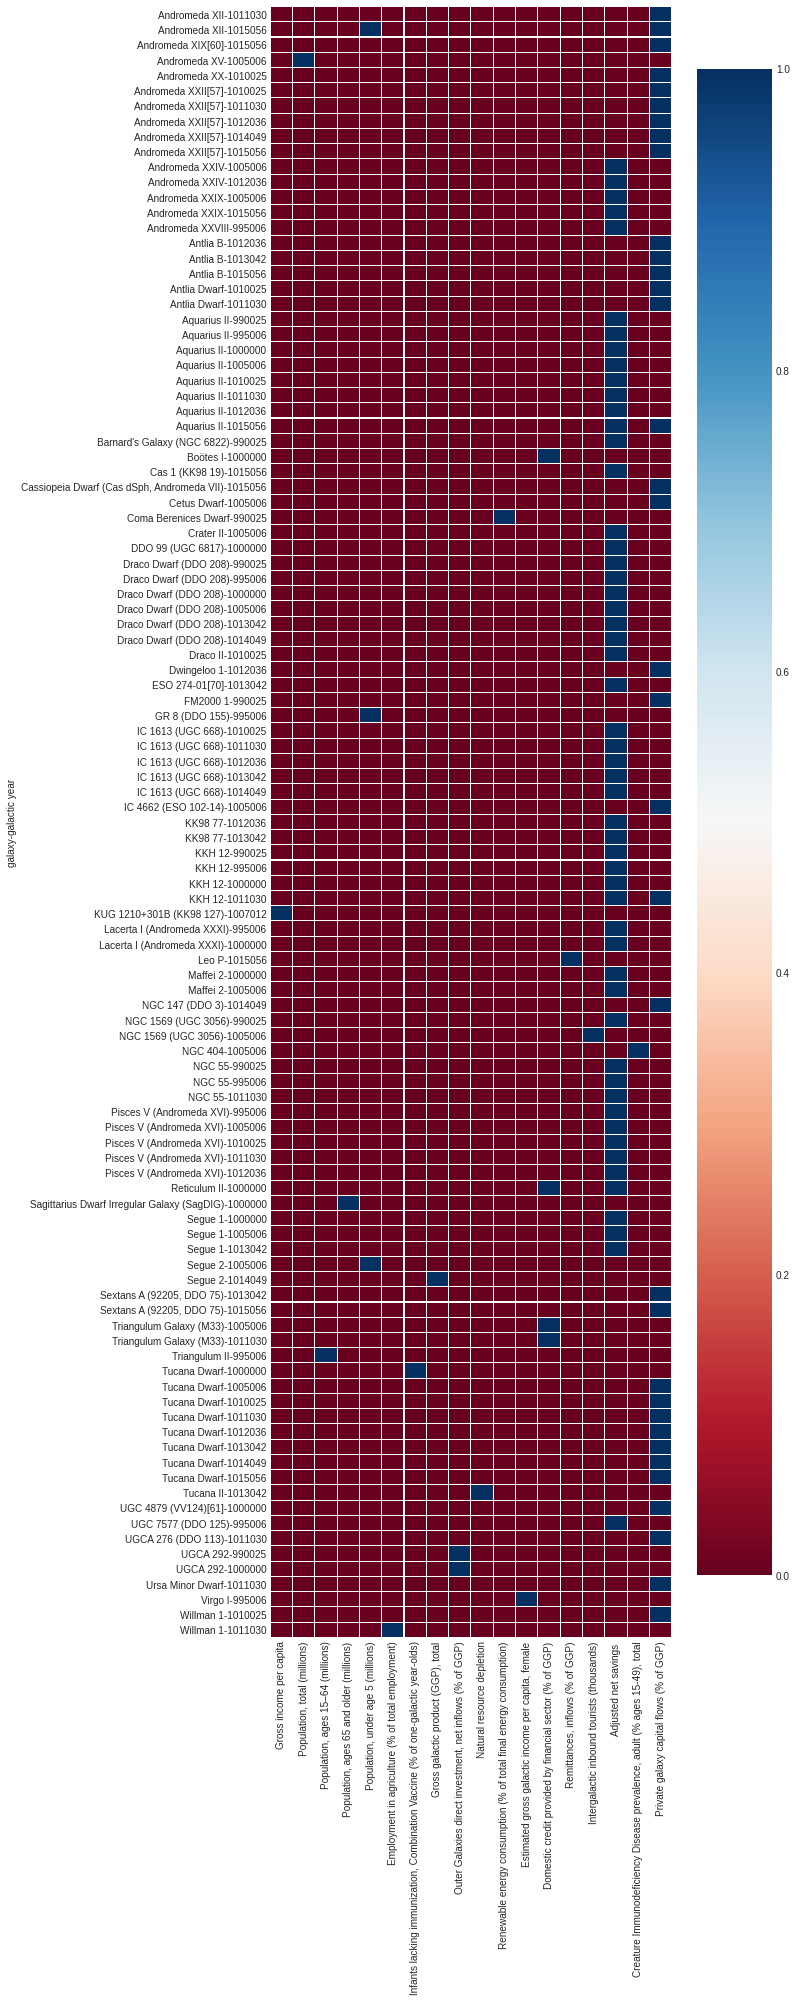

In [6]:
rcParams['figure.figsize'] = 9, 30
data_train_subzero_cols = [x for x in data_train.columns if \
                           (data_train[x].dtype in ['float32', 'int64'] and data_train[x].min() < 0)]
data_train_subzero = data_train[(data_train.drop('galaxy', axis=1) < 0).any(axis=1)][['galaxy', 'galactic year'] + data_train_subzero_cols]
sns.heatmap(data_train_subzero.set_index(['galaxy', 'galactic year']).sort_index() < 0, cmap="RdBu", linewidths=0.05)
display(data_train[data_train_subzero_cols].describe(include='all'))

In [ ]:
rcParams['figure.figsize'] = 18,36

fig = plt.figure()

for i, c in enumerate(data_train_subzero_cols):
    sns.scatterplot(x=data_train[data_train[c] < 0][c], y=data_train['y'], ax=fig.add_subplot(10,3,i+1), )
    sns.scatterplot(x=data_train[data_train[c] >= 0][c], y=data_train['y'],  )
plt.show()


In [ ]:
drop_sub0_columns = ['Adjusted net savings ', 'Private galaxy capital flows (% of GGP)']

In [ ]:
rcParams['figure.figsize'] = 6, 12
data_test_subzero_cols = [x for x in data_test.columns if \
                           (data_test[x].dtype in ['float64', 'int64'] and x != 'y' and data_test[x].min() < 0)]
data_test_subzero = data_test[(data_test.drop(['galaxy', 'y'], axis=1) < 0).any(axis=1)][['galaxy', 'galactic year'] + data_test_subzero_cols]
sns.heatmap(data_test_subzero.set_index(['galaxy', 'galactic year']).sort_index() < 0, cmap="RdBu", linewidths=0.05)
display(data_test[data_test_subzero_cols].describe(include='all'))

In [ ]:
rcParams['figure.figsize'] = 18,18

fig = plt.figure()

for i, c in enumerate(data_test_subzero_cols):
    sns.scatterplot(x=data_test[data_test[c] < 0][c], y=data_test['y'], ax=fig.add_subplot(10,3,i+1), )
    sns.scatterplot(x=data_test[data_test[c] >= 0][c], y=data_test['y'],  )
plt.show()


### Fill NaN

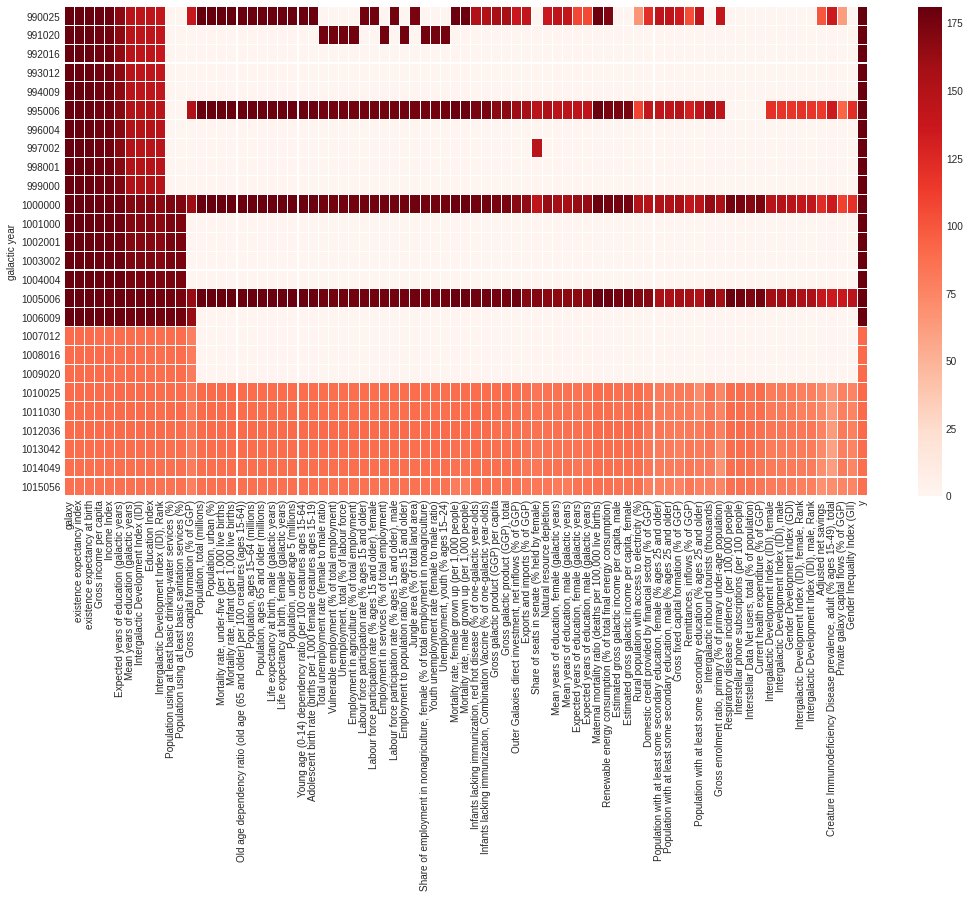

In [8]:
# Кол-во стран с незаполненными атрибутами по года
data = data_all.loc['train']
rcParams['figure.figsize'] = 18, 9

cols_nan = [x for x in data.columns if any((data[x] == data[x])) and x != 'galactic year']
sns.heatmap((data[['galactic year']].join(data[cols_nan] == data[cols_nan])).groupby('galactic year').sum(),
           cmap="Reds", linewidths=0.05);

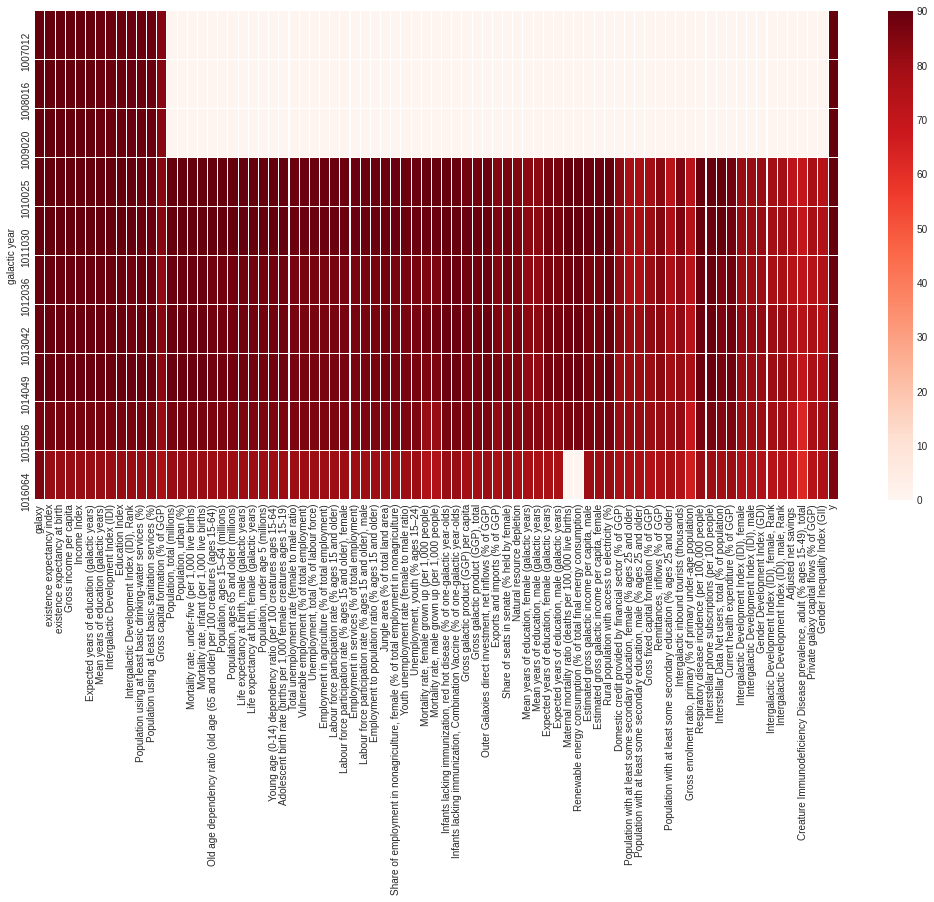

In [9]:
# Кол-во стран с незаполненными атрибутами по года
data = data_all.loc['test']
rcParams['figure.figsize'] = 18, 9

cols_nan = [x for x in data.columns if any((data[x] == data[x])) and x != 'galactic year']
sns.heatmap((data[['galactic year']].join(data[cols_nan] == data[cols_nan])).groupby('galactic year').sum(),
           cmap="Reds", linewidths=0.05);

Периоды с незаполненными признаками заполняем методом ffill.

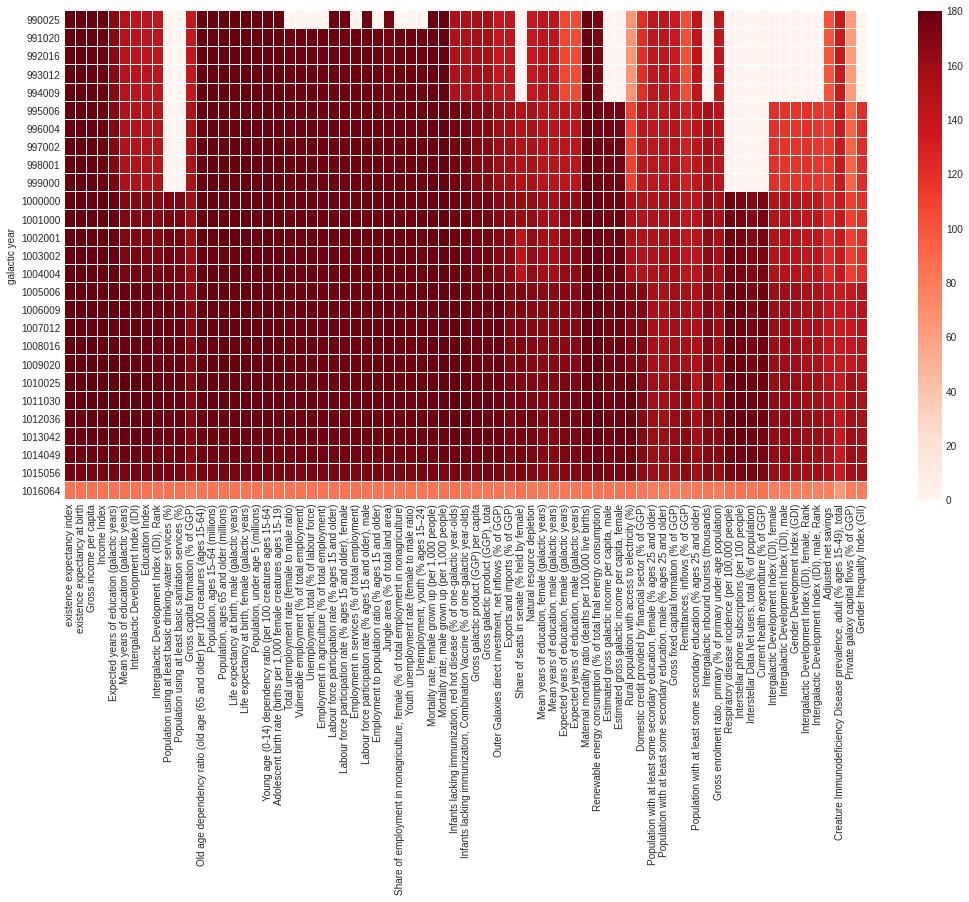

In [92]:
data_all = data_all.sort_values(['galaxy', 'galactic year']).groupby('galaxy', as_index=False).fillna(method='ffill', limit=4)
data = data_all

rcParams['figure.figsize'] = 18, 9

cols_nan = [x for x in data.columns if data[x].isnull().any() and x != 'galactic year']
sns.heatmap((data[['galactic year']].join(data[cols_nan].notna())).groupby('galactic year').sum(),
           cmap="Reds", linewidths=0.05);
plt.show()

## Изучение **y**

             y        y        y
count 3,865.00 3,865.00 3,865.00
mean      0.08     0.08     0.20
std       0.06     0.05     0.03
min       0.01     0.01     0.11
25%       0.05     0.05     0.18
50%       0.06     0.06     0.20
75%       0.09     0.08     0.21
max       0.68     0.52     0.30


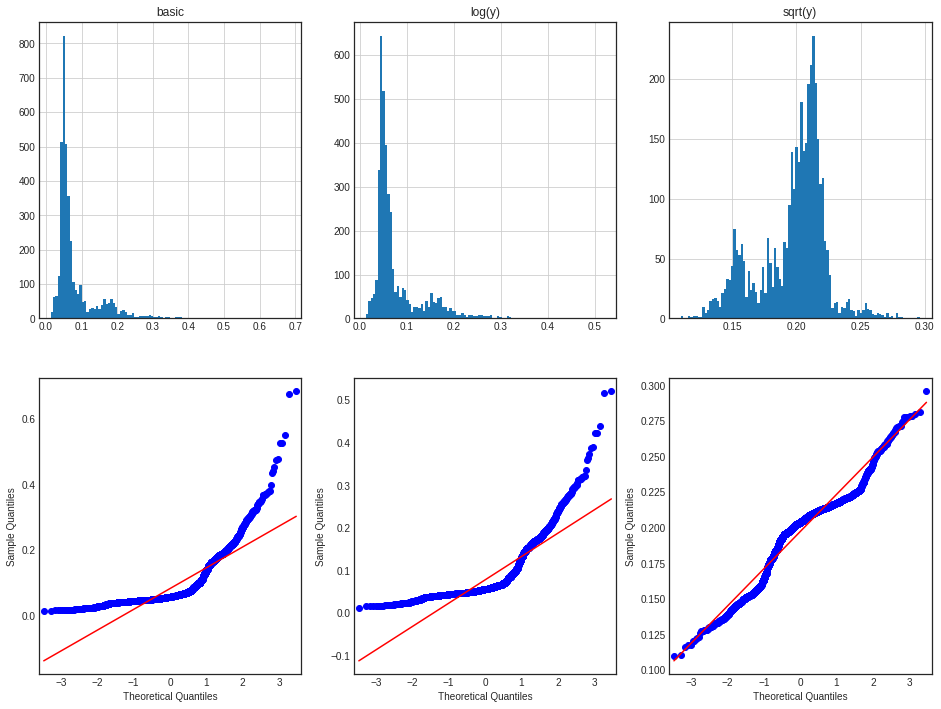

In [11]:
fig, ax = plt.subplots(2,3,figsize=(16,12))

desc_y = data_train['y'].describe()
ax[0,0].set_title('basic')
data_train['y'].hist(bins=100, ax=ax[0,0]);
qqplot(data_train['y'], ax=ax[1,0], line='s', fit=False);

log_y = np.log1p(data_train['y'])
ax[0,1].set_title('log(y)')
log_y.hist(bins=100, ax=ax[0,1]);
qqplot(log_y, ax=ax[1,1], line='s')
desc_y = pd.concat([desc_y, log_y.describe()], axis=1)

root_y = data_train['y'] ** (-1/4) / 10
ax[0,2].set_title('sqrt(y)')
root_y.hist(bins=100, ax=ax[0,2]);
qqplot(root_y, ax=ax[1,2], line='s')
desc_y = pd.concat([desc_y, root_y.describe()], axis=1)
print(desc_y)

plt.show()

-0.5765749460838396


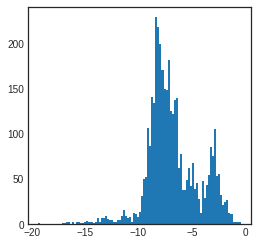

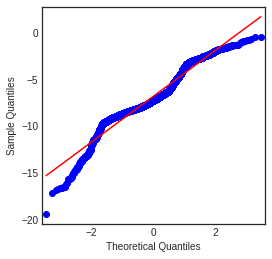

In [13]:
import scipy
data_boxcox, p = scipy.stats.boxcox(data_train['y'])
data_boxcox
rcParams['figure.figsize'] = 4, 4
plt.hist(data_boxcox, bins=100);
qqplot(data_boxcox, line='s');
print(p)

Значения **y** по годам и галактикам:

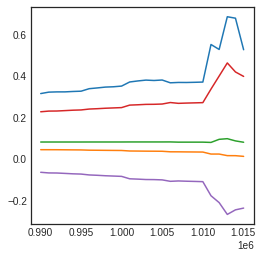

min  mean  max  std
galactic year                     
990025        0.05  0.08 0.31 0.05
991020        0.05  0.08 0.32 0.05
992016        0.04  0.08 0.32 0.05
993012        0.04  0.08 0.32 0.05
994009        0.04  0.08 0.32 0.05
995006        0.04  0.08 0.33 0.05
996004        0.04  0.08 0.34 0.05
997002        0.04  0.08 0.34 0.05
998001        0.04  0.08 0.35 0.05
999000        0.04  0.08 0.35 0.05
1000000       0.04  0.08 0.35 0.06
1001000       0.04  0.08 0.37 0.06
1002001       0.04  0.08 0.38 0.06
1003002       0.04  0.08 0.38 0.06
1004004       0.04  0.08 0.38 0.06
1005006       0.04  0.08 0.38 0.06
1006009       0.03  0.08 0.37 0.06
1007012       0.03  0.08 0.37 0.06
1008016       0.03  0.08 0.37 0.06
1009020       0.03  0.08 0.37 0.06
1010025       0.03  0.08 0.37 0.06
1011030       0.02  0.08 0.55 0.09
1012036       0.02  0.09 0.53 0.10
1013042       0.02  0.10 0.68 0.12
1014049       0.02  0.09 0.68 0.11
1015056       0.01  0.08 0.53 0.11

In [14]:
d = data_train.groupby('galactic year')['y'].agg(['min', 'mean', 'max', 'std']).sort_index()
sns.lineplot(data=d['max']);
sns.lineplot(data=d['min']);
sns.lineplot(data=d['mean']);
sns.lineplot(data=d['mean'] + 3*d['std']);
sns.lineplot(data=d['mean'] - 3*d['std']);
plt.show()
display(d)

In [15]:
data_train.groupby('galaxy')['y'].agg(['min', 'mean', 'max', 'std']).sort_values(by='std', ascending=False)

min  mean  max  std
galaxy                                                          
Cetus Dwarf                                 0.31  0.39 0.68 0.10
Tucana Dwarf                                0.15  0.21 0.53 0.09
ESO 294-010                                 0.25  0.30 0.47 0.07
MB 3                                        0.16  0.19 0.36 0.05
NGC 3741                                    0.27  0.31 0.48 0.05
Leo P                                       0.18  0.21 0.32 0.04
Leo T Dwarf                                 0.22  0.25 0.40 0.04
Canes Venatici II Dwarf                     0.19  0.22 0.32 0.04
IC 10 (UGC 192)                             0.17  0.21 0.30 0.04
Triangulum II                               0.18  0.20 0.29 0.03
Andromeda V                                 0.21  0.23 0.35 0.03
Andromeda IX                                0.15  0.17 0.29 0.03
Maffei 1                                    0.21  0.23 0.32 0.03
Leo IV Dwarf                                0.20  0.23 0.29 0.03
Cassiopeia Dwarf (Cas dSph, Andromeda VII)  0.15  0.18 0.27 0.03
KK98 35                                     0.20  0.23 0.30 0.02
Andromeda XV                                0.14  0.15 0.21 0.02
Pictor II                                   0.17  0.19 0.24 0.02
Segue 2                                     0.03  0.08 0.09 0.02
Canes Venatici I Dwarf                      0.10  0.11 0.17 0.02
Pegasus Dwarf Sph (And VI)                  0.13  0.14 0.18 0.02
Phoenix Dwarf Galaxy (P 6830)               0.17  0.19 0.23 0.01
Andromeda XIX[60]                           0.14  0.15 0.19 0.01
Fornax Dwarf (E356-G04)                     0.15  0.17 0.21 0.01
Andromeda II                                0.14  0.18 0.19 0.01
Reticulum II                                0.06  0.11 0.12 0.01
NGC 5102                                    0.14  0.16 0.18 0.01
MB 1 (KK98 21)                              0.13  0.14 0.17 0.01
IC 3104                                     0.01  0.04 0.05 0.01
Andromeda XVII                              0.02  0.06 0.07 0.01
KKR 25                                      0.02  0.04 0.05 0.01
Eridanus II                                 0.04  0.06 0.07 0.01
Donatiello I                                0.15  0.17 0.18 0.01
Boötes II                                   0.07  0.10 0.10 0.01
NGC 5237                                    0.10  0.12 0.13 0.01
Antlia 2                                    0.10  0.11 0.14 0.01
KKh 060                                     0.02  0.04 0.05 0.01
UGCA 438 (ESO 407-018)                      0.04  0.07 0.07 0.01
KKs 3                                       0.02  0.05 0.05 0.01
Reticulum III                               0.02  0.04 0.05 0.01
Antlia B                                    0.02  0.04 0.05 0.01
Andromeda XXIV                              0.02  0.04 0.05 0.01
Andromeda VIII                              0.02  0.04 0.05 0.01
UGC 8651 (DDO 181)                          0.02  0.04 0.05 0.01
KKH 12                                      0.02  0.04 0.05 0.01
Pegasus III                                 0.02  0.04 0.05 0.01
UGCA 15 (DDO 6)                             0.02  0.05 0.05 0.01
UGC 4483                                    0.02  0.04 0.05 0.01
Segue 1                                     0.02  0.04 0.05 0.01
UGCA 276 (DDO 113)                          0.02  0.04 0.05 0.01
NGC 5206                                    0.02  0.04 0.05 0.01
HIPASS J1247-77                             0.04  0.06 0.07 0.01
Crater II                                   0.02  0.04 0.05 0.01
IC 5152                                     0.03  0.05 0.06 0.01
Cetus III                                   0.02  0.04 0.05 0.01
Horologium II                               0.02  0.04 0.05 0.01
Triangulum Galaxy (M33)                     0.03  0.05 0.05 0.01
Sextans A (92205, DDO 75)                   0.10  0.11 0.14 0.01
Coma Berenices Dwarf                        0.10  0.10 0.13 0.01
Andromeda XI                                0.02  0.04 0.05 0.01
NGC 247        

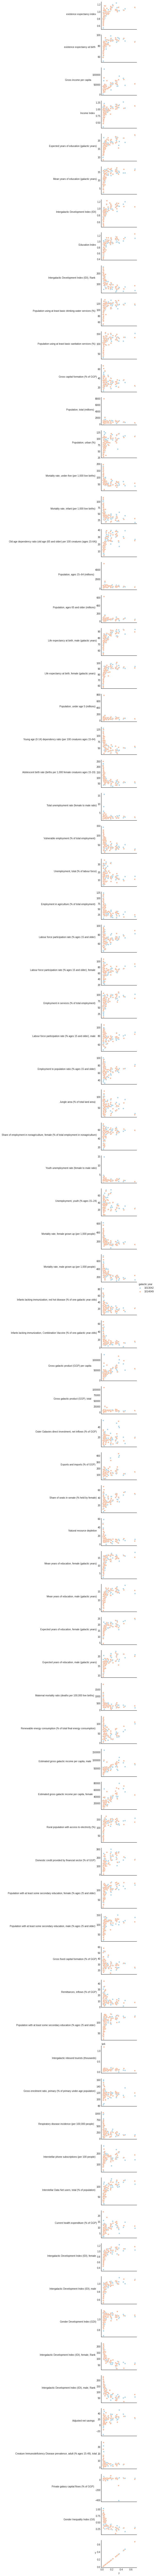

In [16]:
data = data_train.loc[data_train['galactic year'].isin([1013042, 1014049])]
g = sns.pairplot(data, x_vars=['y'], y_vars=data.columns[2:], hue='galactic year', palette='RdBu_r')

for ax in g.axes.flatten():
    
    ax.yaxis.get_label().set_rotation(0)
    ax.yaxis.get_label().set_horizontalalignment('right')

In [ ]:
corr_cols_years = data.corr().columns[data.corr()['y'] > 0.5]

In [ ]:
data = data_train.loc[data_train['galaxy'].isin(['Cetus Dwarf', 'Tucana Dwarf'])]
g = sns.pairplot(data, x_vars=['y'], y_vars=data_corr.columns[2:], hue='galaxy', palette='RdBu_r')

for ax in g.axes.flatten():
    ax.yaxis.get_label().set_rotation(0)
    ax.yaxis.get_label().set_horizontalalignment('right')

In [ ]:
corr_cols_galaxy = data.corr().columns[data.corr()['y'] > 0.5]

In [ ]:
corr_cols = list(corr_cols_galaxy.intersection(corr_cols_years))
corr_cols.remove('y')
corr_cols

## Features

### Функция для анализа данных

In [122]:
def show_hist(data, cols):
    """Hstograms"""
    print('Data distribution:', '\n')
    fig = plt.figure(1, figsize=(14,30))
    for i, c in enumerate(cols):
        data_wrk = data[c]
        sns.distplot(data_wrk, bins=50, ax=fig.add_subplot(10, 3, i+1),);
        fig.axes[-1].set_title('\n'.join(wrap(c, 30)))
    plt.tight_layout()
    plt.show(1)
    plt.close(1)

def show_qqplot(data, cols):
    """Q-Q plot"""
    print('Q-Q Plot:', '\n')
    fig = plt.figure(figsize=(14,30))
    for i, c in enumerate(cols):
        data_wrk = data[c]
        qqplot(data_wrk, ax=fig.add_subplot(10, 3, i+1),);
        fig.axes[-1].set_title('\n'.join(wrap(c, 30)))
    plt.tight_layout()    
    plt.show()
    plt.close()

def show_scatter(data, cols):
    """Scatter"""
    print('XY:', '\n')
    fig = plt.figure(figsize=(14,30))
    for i, c in enumerate(cols):
        data_wrk = data[c]
        sns.scatterplot(data=data, x=c, y=data['y'], ax=fig.add_subplot(10, 3, i+1),);
        fig.axes[-1].set_title('\n'.join(wrap(c, 30)))
    plt.tight_layout()
    plt.show()
    plt.close()
    
def show_xy(data, cols):
    """Lineplot"""
    print('By year:', '\n')
    fig = plt.figure(figsize=(14,30))
    for i, c in enumerate(cols):
        data_wrk = data_train.groupby('galactic year')[c].\
                     agg(['min', 'mean', 'max', 'std']).sort_index()
        data_wrk['min_std'] = data_wrk['mean'] - 3 * data_wrk['std'] 
        data_wrk['max_std'] = data_wrk['mean'] + 3 * data_wrk['std'] 
        data_wrk = data_wrk[['min', 'max', 'mean', 'min_std', 'max_std']]
        sns.lineplot(data=data_wrk, ax=fig.add_subplot(10, 3, i+1),);
        fig.axes[-1].set_title('\n'.join(wrap(c, 30)))
    plt.tight_layout()
    plt.show()
    plt.close()

def show_nans(data, cols):
    """NaNs by years"""
    print('NaNs:', '\n')
    fig = plt.figure(figsize=(14,30))
    for i, c in enumerate(cols):
        if c != 'y':
            data_wrk1 = data_train.groupby('galactic year')[c].count() / data_train.groupby('galactic year')[c].size()
            sns.lineplot(data=data_wrk1, ax=fig.add_subplot(10, 3, i+1),);
            data_wrk2 = data_test.groupby('galactic year')[c].count() / data_test.groupby('galactic year')[c].size()
            sns.lineplot(data=data_wrk2, ax=fig.add_subplot(10, 3, i+1),);
            fig.axes[-1].set_title('\n'.join(wrap(c, 30)))
    plt.tight_layout()
    plt.show()
    plt.close()
    
def show_box(data, cols):
    """Boxplot"""
    print('Box:', '\n')
    fig = plt.figure(figsize=(14,30))
    for i, c in enumerate(cols):
        if c != 'y':
            sns.boxplot(data=[data_train[c], data_test[c]], ax=fig.add_subplot(10, 3, i+1),);
            fig.axes[-1].set_title('\n'.join(wrap(c, 30)))
    plt.tight_layout()
    plt.show()
    plt.close()
    
def data_desc(data, cols=[], start_col=0, n_cols=11):
    """Description for data
    data - Dataset;
    cols - Columns for subset;
    start_col - Start No. of column subset;
    n_cols - Number of columns in subset. Default 10 for good screen fitting;
    """
    cols = cols.copy()
    if not cols:
        i = start_col
        cols = list(data.drop(['galaxy', 'galactic year', 'y'], axis=1).columns[start_col:min(data.shape[1], start_col + n_cols)])
    cols.append('y')
#    print('Data head:', '\n')
#    display(data[cols].head(10))
    print('Data description:', '\n')
    display(data[cols].describe(include='all'))
    
#    show_hist(data, cols)
    
#    show_qqplot(data, cols)

    show_scatter(data, cols)

#    show_xy(data, cols)

    show_box(data, cols)
    
    show_nans(data, cols)
    
    print('Data correlation:', '\n')
    display(pd.concat([data[cols].corrwith(data['y'], method='pearson'), 
                       data[cols].corrwith(data['y'], method='kendall'), 
                       data[cols].corrwith(data['y'], method='spearman'),
                       data[cols].skew(axis=0)], axis=1, keys=['pearson', 'kendall', 'spearman', 'skew']))
    cols.remove('y')
    return cols

### Признаки

In [142]:
features_with_outliers = []
features_drop = []

In [22]:
data_train = data_all.loc['train']
data_test = data_all.loc['test']

#### Группа 1:

Data description: 



existence expectancy index  existence expectancy at birth  \
count                    3,864.00                       3,864.00   
mean                         0.87                          76.80   
std                          0.16                          10.46   
min                          0.23                          34.24   
25%                          0.76                          69.96   
50%                          0.91                          79.00   
75%                          0.99                          84.56   
max                          1.25                         100.21   

       Gross income per capita  Income Index  \
count                 3,837.00      3,837.00   
mean                 31,633.24          0.83   
std                  18,736.38          0.19   
min                    -126.91          0.29   
25%                  20,169.12          0.68   
50%                  26,600.77          0.83   
75%                  36,898.63          0.97   
max                 151,072.69          1.36   

       Expected years of education (galactic years)  \
count                                      3,734.00   
mean                                          14.72   
std                                            3.61   
min                                            3.80   
25%                                           12.59   
50%                                           14.95   
75%                                           17.13   
max                                           26.96   

       Mean years of education (galactic years)  \
count                                  3,502.00   
mean                                      10.28   
std                                        3.32   
min                                        1.93   
25%                                        7.65   
50%                                       10.39   
75%                                       12.88   
max                                       19.06   

       Intergalactic Development Index (IDI)  Education Index  \
count                               3,476.00         3,476.00   
mean                                    0.80             0.75   
std                                     0.18             0.20   
min                                     0.27             0.19   
25%                                     0.67             0.60   
50%                                     0.82             0.76   
75%                                     0.94             0.89   
max                                     1.23             1.27   

       Intergalactic Development Index (IDI), Rank  \
count                                     3,435.00   
mean                                        135.10   
std                                          52.45   
min                                           9.93   
25%                                          92.06   
50%                                         135.90   
75%                                         175.29   
max                                         278.79   

       Population using at least basic drinking-water services (%)  \
count                                           2,021.00             
mean                                              101.89             
std                                                20.32             
min                                                33.14             
25%                                                89.47             
50%                                               108.42             
75%                                               116.90             
max                                               136.32             

       Population using at least basic sanitation services (%)        y  
count                                           2,015.00       3,865.00  
mean                                               99.94           0.08  
std                                                32.36           0.06  
min  

XY: 



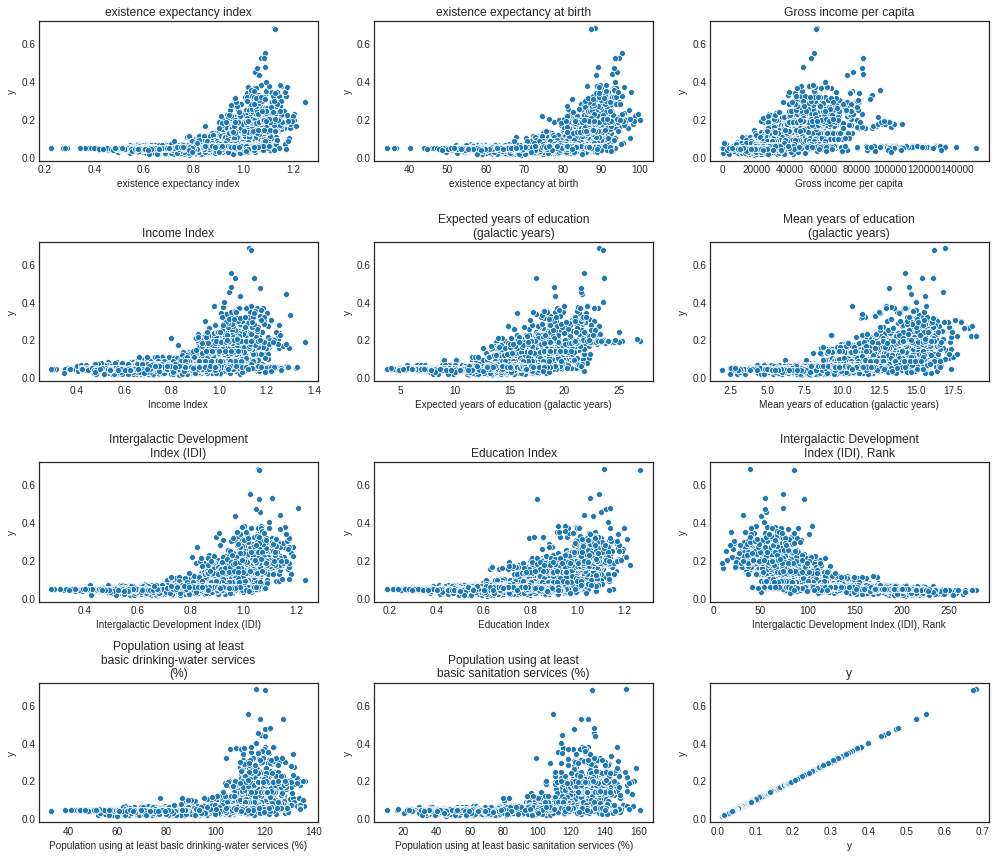

Box: 



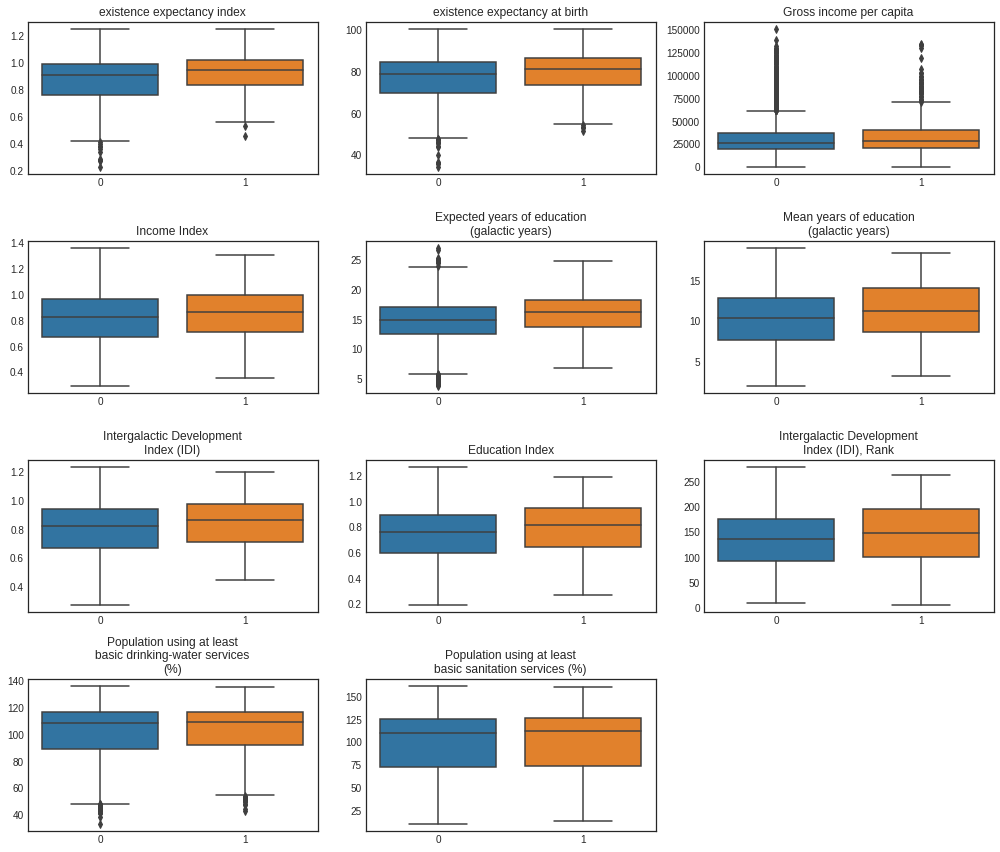

NaNs: 



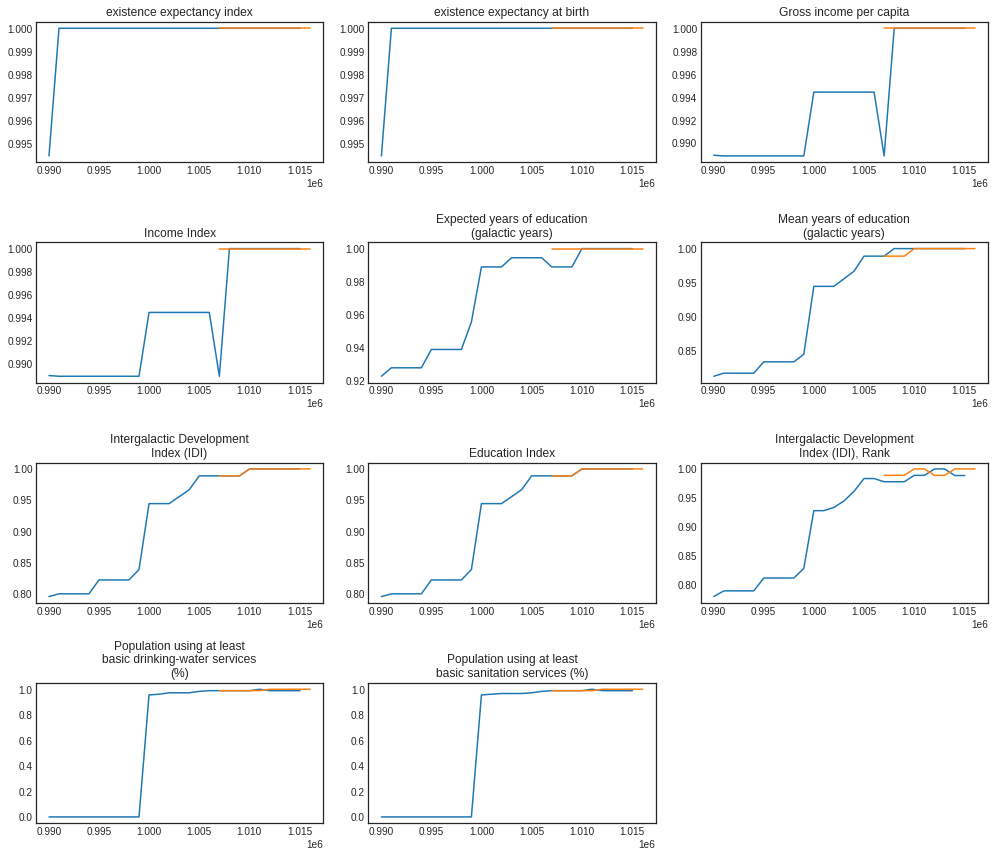

Data correlation: 



pearson  kendall  \
existence expectancy index                             0.55     0.51   
existence expectancy at birth                          0.56     0.52   
Gross income per capita                                0.51     0.40   
Income Index                                           0.58     0.48   
Expected years of education (galactic years)           0.58     0.46   
Mean years of education (galactic years)               0.58     0.49   
Intergalactic Development Index (IDI)                  0.63     0.54   
Education Index                                        0.61     0.50   
Intergalactic Development Index (IDI), Rank           -0.68    -0.64   
Population using at least basic drinking-water ...     0.43     0.44   
Population using at least basic sanitation serv...     0.48     0.47   
y                                                      1.00     1.00   

                                                    spearman  skew  
existence expectancy index                              0.71 -0.62  
existence expectancy at birth                           0.72 -0.63  
Gross income per capita                                 0.56  2.11  
Income Index                                            0.65  0.00  
Expected years of education (galactic years)            0.64 -0.23  
Mean years of education (galactic years)                0.68 -0.06  
Intergalactic Development Index (IDI)                   0.74 -0.30  
Education Index                                         0.69 -0.17  
Intergalactic Development Index (IDI), Rank            -0.82  0.06  
Population using at least basic drinking-water ...      0.63 -0.93  
Population using at least basic sanitation serv...      0.66 -0.58  
y                                                       1.00  2.66

['existence expectancy index',
 'existence expectancy at birth',
 'Gross income per capita',
 'Income Index',
 'Expected years of education (galactic years)',
 'Mean years of education (galactic years)',
 'Intergalactic Development Index (IDI)',
 'Education Index',
 'Intergalactic Development Index (IDI), Rank',
 'Population using at least basic drinking-water services (%)',
 'Population using at least basic sanitation services (%)']

In [123]:
data_desc(data_train, start_col=0)

In [ ]:
features_with_outliers += ['Gross income per capita']

In [ ]:
sns.boxplot(data=[data_train['Gross income per capita'], data_test['Gross income per capita']])

In [ ]:
sns.boxplot(data=[np.log1p(data_train['Gross income per capita']), np.log1p(data_test['Gross income per capita'])])

#### Группа 2:

Data description: 



Gross capital formation (% of GGP)  Population, total (millions)  \
count                            3,324.00                      3,865.00   
mean                                31.28                        811.47   
std                                  8.51                        565.46   
min                                  2.49                       -160.44   
25%                                 26.48                        598.00   
50%                                 30.97                        762.53   
75%                                 35.79                        951.92   
max                                 72.31                      7,993.32   

       Population, urban (%)  \
count               3,865.00   
mean                   75.54   
std                    24.11   
min                    20.78   
25%                    55.78   
50%                    76.51   
75%                    95.48   
max                   129.91   

       Mortality rate, under-five (per 1,000 live births)  \
count                                           3,865.00    
mean                                              106.45    
std                                                62.49    
min                                                 9.72    
25%                                                60.51    
50%                                                85.70    
75%                                               137.63    
max                                               379.42    

       Mortality rate, infant (per 1,000 live births)  \
count                                        3,865.00   
mean                                            70.62   
std                                             37.45   
min                                             12.79   
25%                                             42.09   
50%                                             58.84   
75%                                             93.85   
max                                            208.50   

       Old age dependency ratio (old age (65 and older) per 100 creatures (ages 15-64))  \
count                                           3,842.00                                  
mean                                               18.47                                  
std                                                 6.97                                  
min                                                 4.30                                  
25%                                                13.56                                  
50%                                                16.49                                  
75%                                                22.68                                  
max                                                52.22                                  

       Population, ages 15–64 (millions)  \
count                           3,842.00   
mean                              531.11   
std                               359.25   
min                               -91.29   
25%                               389.99   
50%                               501.58   
75%                               617.05   
max                             5,542.81   

       Population, ages 65 and older (millions)  \
count                                  3,842.00   
mean                                      58.91   
std                                       39.85   
min                                      -23.66   
25%                                       42.82   
50%                                       55.75   
75%                                       68.94   
max                                      649.49   

       Life expectancy at birth, male (galactic years)  \
count                                         3,842.00   
mean                                             73.23   
std                                              10.16   
min                                              39.16   
25%        

XY: 



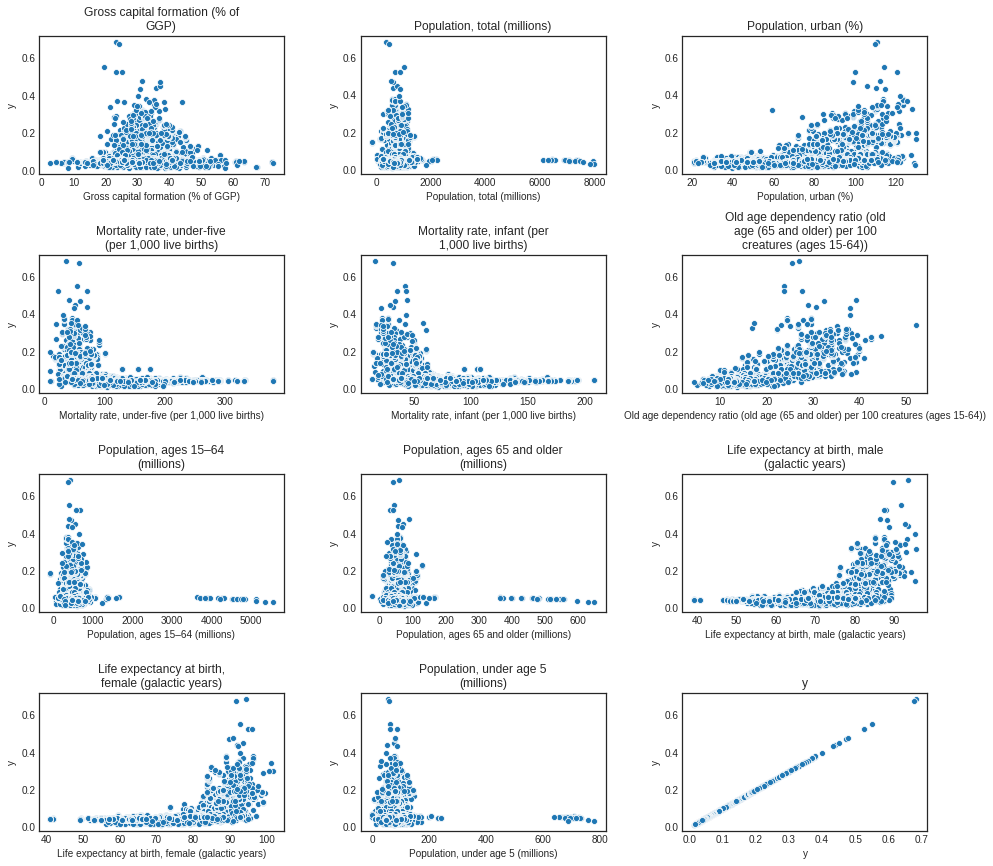

Box: 



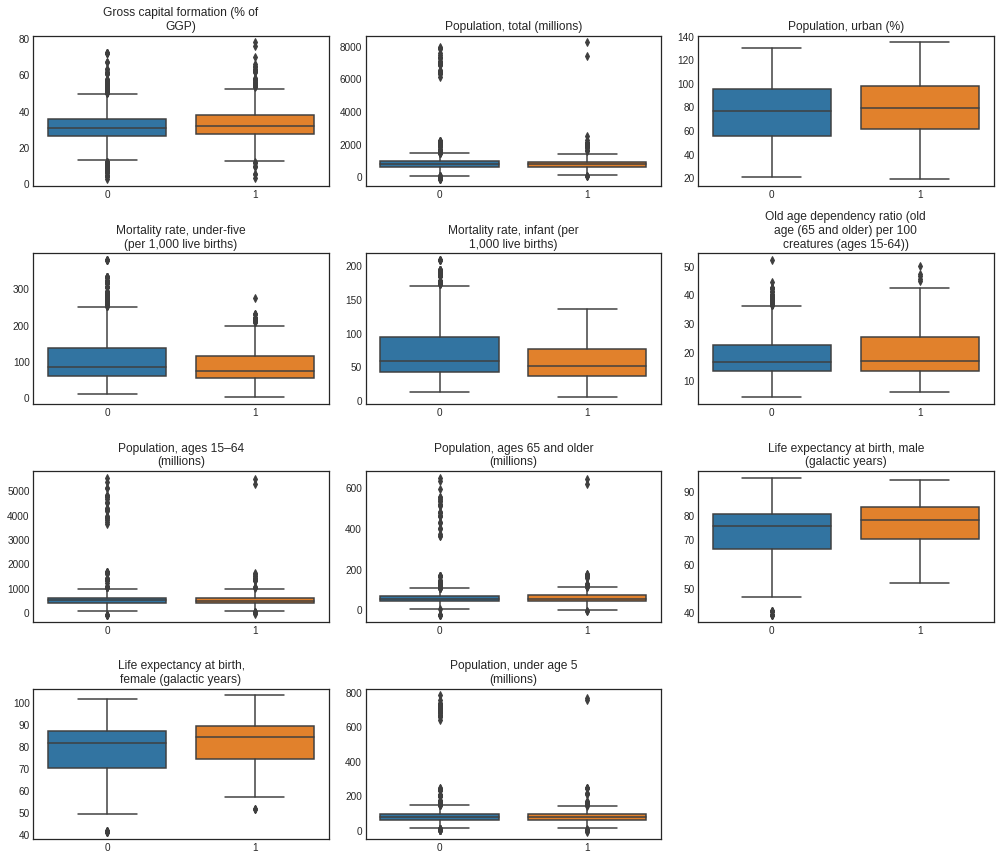

NaNs: 



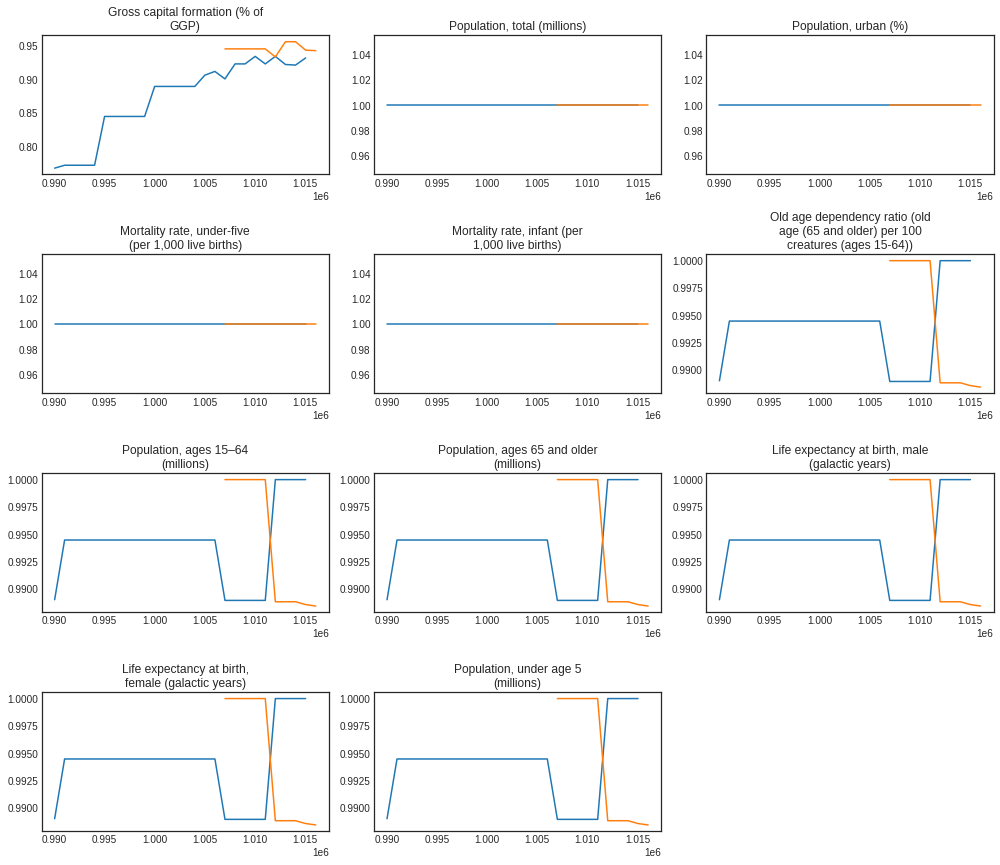

Data correlation: 



pearson  kendall  \
Gross capital formation (% of GGP)                     0.07     0.11   
Population, total (millions)                          -0.05     0.01   
Population, urban (%)                                  0.50     0.39   
Mortality rate, under-five (per 1,000 live births)    -0.44    -0.47   
Mortality rate, infant (per 1,000 live births)        -0.49    -0.49   
Old age dependency ratio (old age (65 and older...     0.71     0.49   
Population, ages 15–64 (millions)                     -0.06    -0.02   
Population, ages 65 and older (millions)              -0.03     0.01   
Life expectancy at birth, male (galactic years)        0.55     0.50   
Life expectancy at birth, female (galactic years)      0.55     0.55   
Population, under age 5 (millions)                    -0.05     0.00   
y                                                      1.00     1.00   

                                                    spearman  skew  
Gross capital formation (% of GGP)                      0.16  0.43  
Population, total (millions)                            0.02  8.34  
Population, urban (%)                                   0.57 -0.08  
Mortality rate, under-five (per 1,000 live births)     -0.67  1.24  
Mortality rate, infant (per 1,000 live births)         -0.68  0.97  
Old age dependency ratio (old age (65 and older...      0.68  0.92  
Population, ages 15–64 (millions)                      -0.03  8.64  
Population, ages 65 and older (millions)                0.02  8.63  
Life expectancy at birth, male (galactic years)         0.69 -0.59  
Life expectancy at birth, female (galactic years)       0.74 -0.64  
Population, under age 5 (millions)                      0.00  8.45  
y                                                       1.00  2.66

['Gross capital formation (% of GGP)',
 'Population, total (millions)',
 'Population, urban (%)',
 'Mortality rate, under-five (per 1,000 live births)',
 'Mortality rate, infant (per 1,000 live births)',
 'Old age dependency ratio (old age (65 and older) per 100 creatures (ages 15-64))',
 'Population, ages 15–64 (millions)',
 'Population, ages 65 and older (millions)',
 'Life expectancy at birth, male (galactic years)',
 'Life expectancy at birth, female (galactic years)',
 'Population, under age 5 (millions)']

In [124]:
data_desc(data_train, start_col=11)

In [ ]:
features_with_outliers += ['Population, total (millions)', 'Population, ages 15–64 (millions)',
 'Population, ages 65 and older (millions)',  'Population, under age 5 (millions)']

In [125]:
data_all['Population, ages 15–64'] = data_all['Population, ages 15–64 (millions)'] / data_all['Population, total (millions)']
data_all['Population, ages 65 and older'] = data_all['Population, ages 65 and older (millions)'] / data_all['Population, total (millions)']
data_all['Population, under age 5'] = data_all['Population, under age 5 (millions)'] / data_all['Population, total (millions)']
data_all['Under 5 per 15-64'] = data_all['Population, under age 5 (millions)']/data_all['Population, ages 15–64 (millions)']

In [135]:
data_all['Mortality rate, kids (per 1,000 live births)'] = data_all['Mortality rate, under-five (per 1,000 live births)'] \
                                                            + data_all['Mortality rate, infant (per 1,000 live births)'] 

In [143]:
features_drop += ['Population, total (millions)', 'Population, ages 15–64 (millions)',
                  'Population, ages 65 and older (millions)',  'Population, under age 5 (millions)']  
features_drop

['Population, total (millions)',
 'Population, ages 15–64 (millions)',
 'Population, ages 65 and older (millions)',
 'Population, under age 5 (millions)']

#### Группа 3:

Data description: 



Young age (0-14) dependency ratio (per 100 creatures ages 15-64)  \
count                                           3,842.00                  
mean                                               82.04                  
std                                                25.33                  
min                                                11.62                  
25%                                                60.23                  
50%                                                82.01                  
75%                                               103.84                  
max                                               137.20                  

       Adolescent birth rate (births per 1,000 female creatures ages 15-19)  \
count                                           3,842.00                      
mean                                              118.67                      
std                                                53.96                      
min                                                14.34                      
25%                                                77.00                      
50%                                               109.32                      
75%                                               151.72                      
max                                               289.81                      

       Total unemployment rate (female to male ratio)  \
count                                        3,625.00   
mean                                             2.73   
std                                              1.15   
min                                              0.93   
25%                                              2.19   
50%                                              2.56   
75%                                              3.08   
max                                             29.66   

       Vulnerable employment (% of total employment)  \
count                                       3,625.00   
mean                                           69.75   
std                                            29.98   
min                                            11.66   
25%                                            45.35   
50%                                            65.38   
75%                                            94.94   
max                                           143.93   

       Unemployment, total (% of labour force)  \
count                                 3,625.00   
mean                                     14.66   
std                                       6.93   
min                                       1.96   
25%                                       9.76   
50%                                      13.24   
75%                                      17.98   
max                                      44.85   

       Employment in agriculture (% of total employment)  \
count                                           3,625.00   
mean                                               55.93   
std                                                25.49   
min                                                -0.68   
25%                                                35.07   
50%                                                52.15   
75%                                                74.04   
max                                               131.09   

       Labour force participation rate (% ages 15 and older)  \
count                                           3,802.00       
mean                                               72.81       
std                                                10.75       
min                                                44.24       
25%                                                65.55       
50%                                                72.27       
75%                                                79.47       
max                                               103.90       

       Labour force participati

XY: 



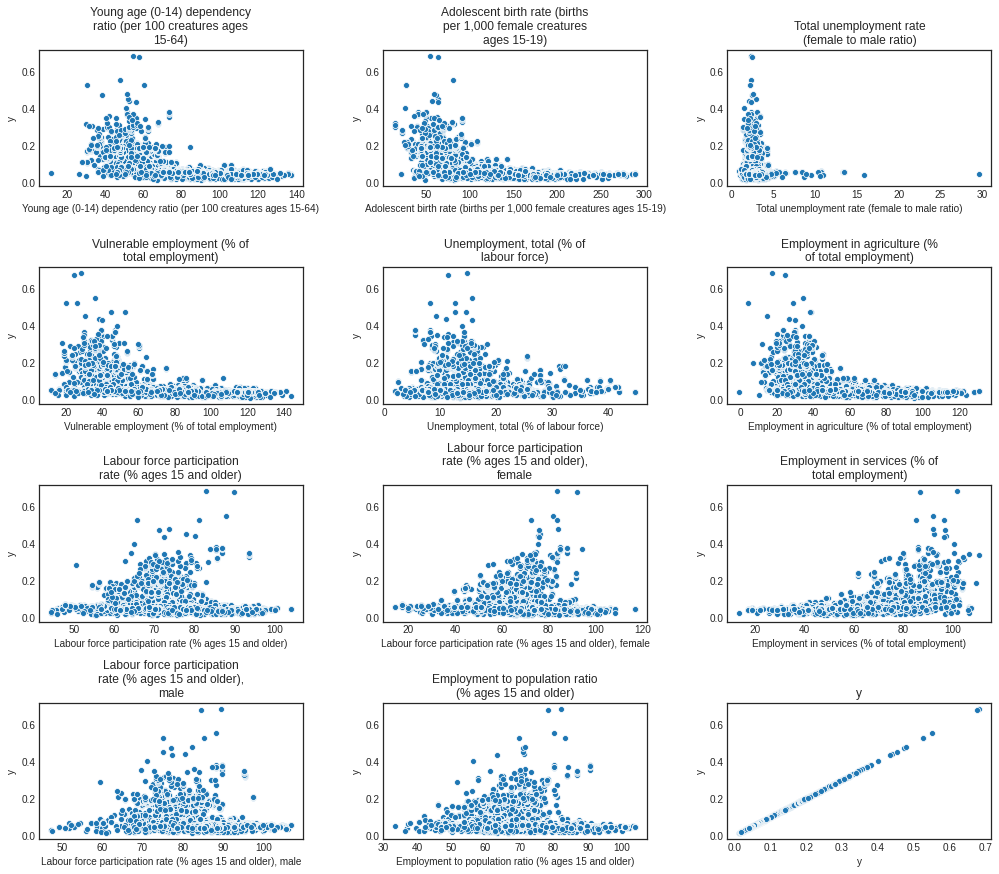

By year: 



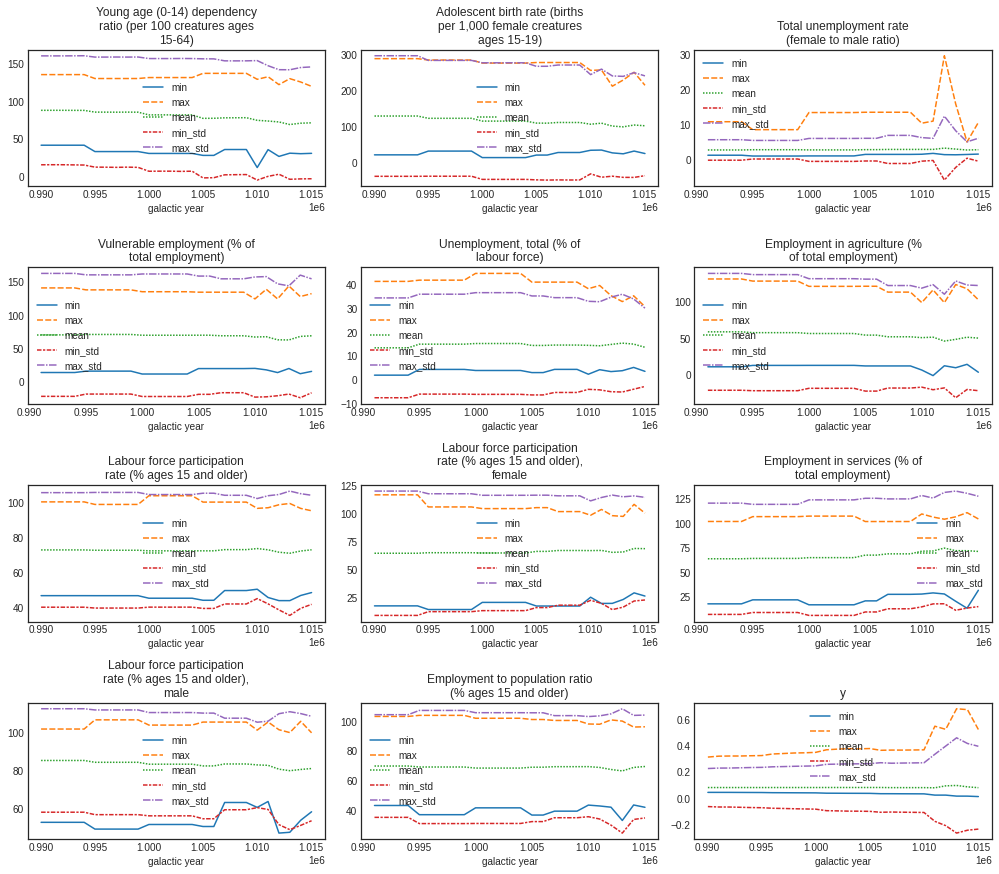

NaNs: 



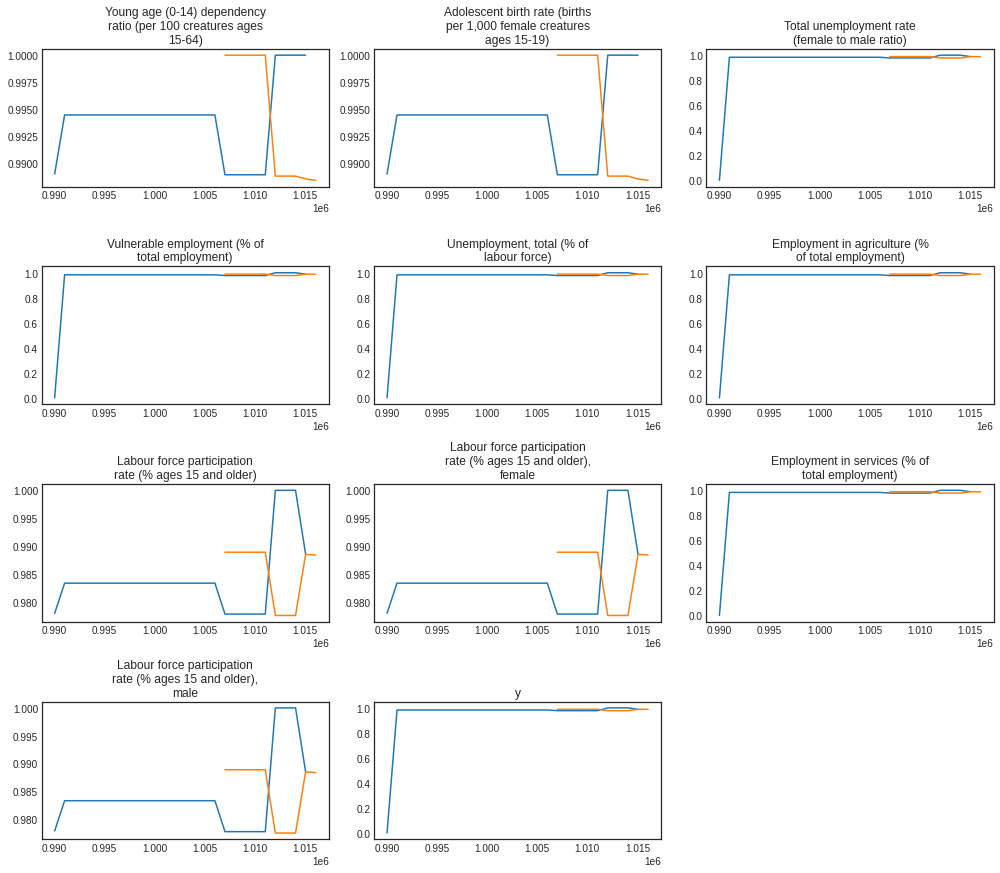

Data correlation: 



pearson  kendall  \
Young age (0-14) dependency ratio (per 100 crea...    -0.60    -0.53   
Adolescent birth rate (births per 1,000 female ...    -0.52    -0.46   
Total unemployment rate (female to male ratio)        -0.07    -0.01   
Vulnerable employment (% of total employment)         -0.51    -0.47   
Unemployment, total (% of labour force)               -0.04     0.06   
Employment in agriculture (% of total employment)     -0.51    -0.44   
Labour force participation rate (% ages 15 and ...    -0.08    -0.14   
Labour force participation rate (% ages 15 and ...     0.04    -0.07   
Employment in services (% of total employment)         0.50     0.40   
Labour force participation rate (% ages 15 and ...    -0.24    -0.21   
Employment to population ratio (% ages 15 and o...    -0.05    -0.11   
y                                                      1.00     1.00   

                                                    spearman  skew  
Young age (0-14) dependency ratio (per 100 crea...     -0.72  0.02  
Adolescent birth rate (births per 1,000 female ...     -0.64  0.71  
Total unemployment rate (female to male ratio)         -0.02  7.36  
Vulnerable employment (% of total employment)          -0.65  0.29  
Unemployment, total (% of labour force)                 0.09  1.34  
Employment in agriculture (% of total employment)      -0.62  0.47  
Labour force participation rate (% ages 15 and ...     -0.21  0.18  
Labour force participation rate (% ages 15 and ...     -0.13 -0.20  
Employment in services (% of total employment)          0.57 -0.20  
Labour force participation rate (% ages 15 and ...     -0.30 -0.38  
Employment to population ratio (% ages 15 and o...     -0.17  0.17  
y                                                       1.00  2.66

['Young age (0-14) dependency ratio (per 100 creatures ages 15-64)',
 'Adolescent birth rate (births per 1,000 female creatures ages 15-19)',
 'Total unemployment rate (female to male ratio)',
 'Vulnerable employment (% of total employment)',
 'Unemployment, total (% of labour force)',
 'Employment in agriculture (% of total employment)',
 'Labour force participation rate (% ages 15 and older)',
 'Labour force participation rate (% ages 15 and older), female',
 'Employment in services (% of total employment)',
 'Labour force participation rate (% ages 15 and older), male',
 'Employment to population ratio (% ages 15 and older)']

In [28]:
data_desc(data_train, start_col=22)

In [141]:
features_drop += []
features_drop

['Population, total (millions)',
 'Population, ages 15–64 (millions)',
 'Population, ages 65 and older (millions)',
 'Population, under age 5 (millions)',
 'Total unemployment rate (female to male ratio)']

In [ ]:
features_with_outliers += ['Total unemployment rate (female to male ratio)']

#### Группа 4:

Data description: 



Jungle area (% of total land area)  \
count                            3,787.00   
mean                                55.41   
std                                 25.09   
min                                  7.13   
25%                                 34.70   
50%                                 52.99   
75%                                 73.17   
max                                134.47   

       Share of employment in nonagriculture, female (% of total employment in nonagriculture)  \
count                                           3,625.00                                         
mean                                               49.60                                         
std                                                12.00                                         
min                                                13.02                                         
25%                                                44.52                                         
50%                                                51.93                                         
75%                                                57.27                                         
max                                                79.49                                         

       Youth unemployment rate (female to male ratio)  \
count                                        3,621.00   
mean                                             2.23   
std                                              0.73   
min                                              0.61   
25%                                              1.81   
50%                                              2.15   
75%                                              2.54   
max                                             14.80   

       Unemployment, youth (% ages 15–24)  \
count                            3,621.00   
mean                                29.36   
std                                 12.89   
min                                  4.48   
25%                                 20.15   
50%                                 26.29   
75%                                 36.29   
max                                 84.10   

       Mortality rate, female grown up (per 1,000 people)  \
count                                           3,842.00    
mean                                              278.27    
std                                               121.51    
min                                                65.33    
25%                                               189.23    
50%                                               245.23    
75%                                               342.57    
max                                               764.79    

       Mortality rate, male grown up (per 1,000 people)  \
count                                          3,842.00   
mean                                             358.29   
std                                              126.93   
min                                               75.17   
25%                                              263.10   
50%                                              338.62   
75%                                              434.11   
max                                              854.03   

       Infants lacking immunization, red hot disease (% of one-galactic year-olds)  \
count                                           3,672.00                             
mean                                               33.91                             
std                                                17.95                             
min                                                 2.34                             
25%                                                20.97                             
50%                                                29.07                             
75%                                                43.28                             
max                         

XY: 



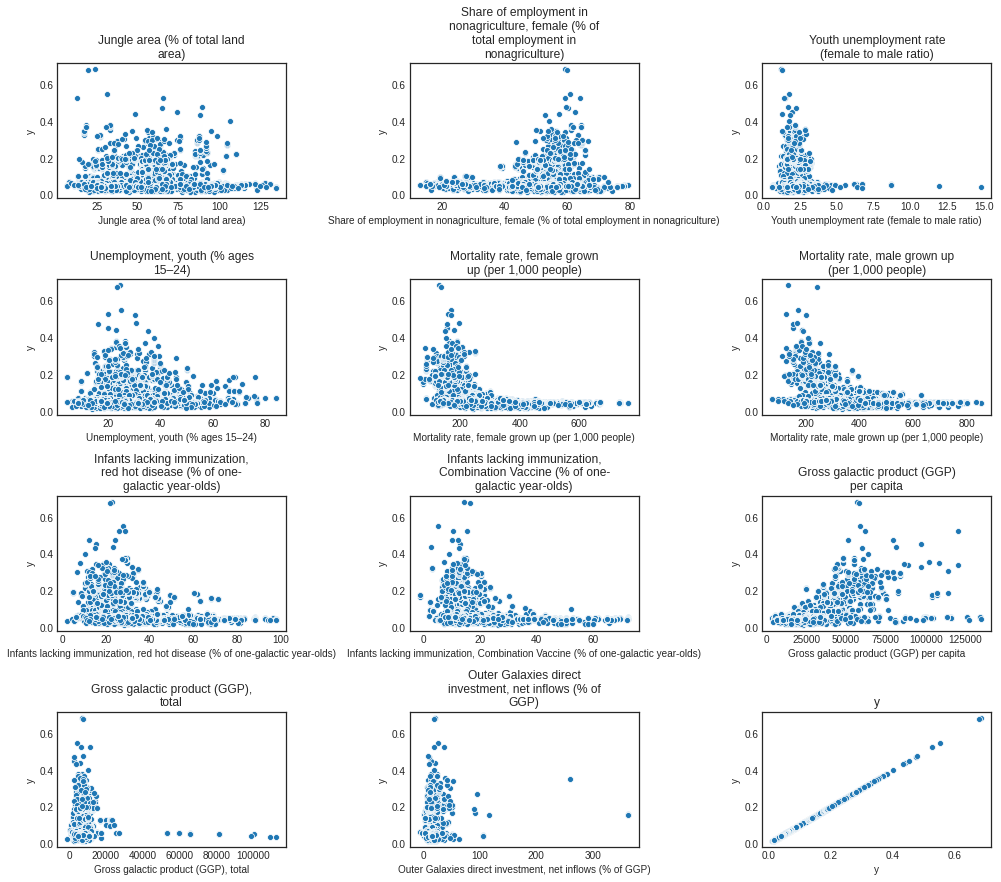

Box: 



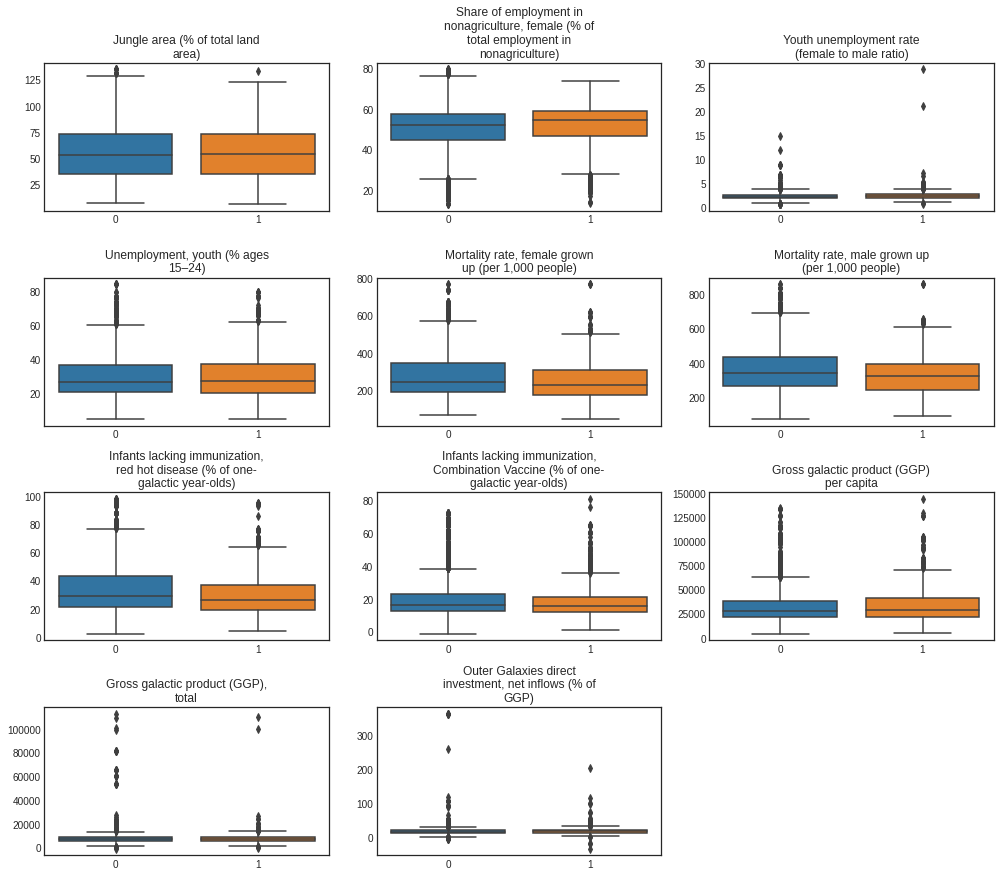

NaNs: 



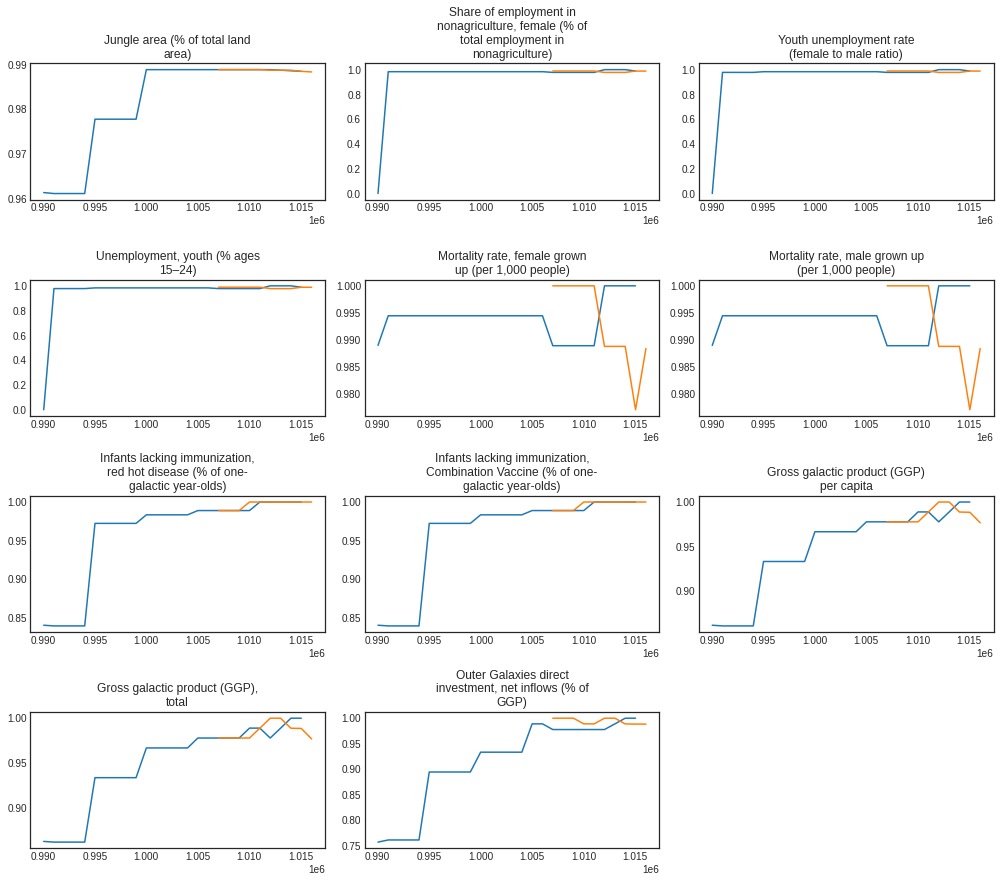

Data correlation: 



pearson  kendall  \
Jungle area (% of total land area)                    -0.01    -0.01   
Share of employment in nonagriculture, female (...     0.21     0.10   
Youth unemployment rate (female to male ratio)        -0.11    -0.02   
Unemployment, youth (% ages 15–24)                    -0.01     0.08   
Mortality rate, female grown up (per 1,000 people)    -0.48    -0.51   
Mortality rate, male grown up (per 1,000 people)      -0.48    -0.42   
Infants lacking immunization, red hot disease (...    -0.26    -0.25   
Infants lacking immunization, Combination Vacci...    -0.28    -0.27   
Gross galactic product (GGP) per capita                0.54     0.42   
Gross galactic product (GGP), total                    0.01     0.07   
Outer Galaxies direct investment, net inflows (...     0.09     0.02   
y                                                      1.00     1.00   

                                                    spearman  skew  
Jungle area (% of total land area)                     -0.01  0.44  
Share of employment in nonagriculture, female (...      0.15 -0.77  
Youth unemployment rate (female to male ratio)         -0.03  4.17  
Unemployment, youth (% ages 15–24)                      0.13  1.07  
Mortality rate, female grown up (per 1,000 people)     -0.70  1.11  
Mortality rate, male grown up (per 1,000 people)       -0.59  0.82  
Infants lacking immunization, red hot disease (...     -0.37  1.09  
Infants lacking immunization, Combination Vacci...     -0.39  1.98  
Gross galactic product (GGP) per capita                 0.58  2.09  
Gross galactic product (GGP), total                     0.11  9.84  
Outer Galaxies direct investment, net inflows (...      0.03 16.18  
y                                                       1.00  2.66

['Jungle area (% of total land area)',
 'Share of employment in nonagriculture, female (% of total employment in nonagriculture)',
 'Youth unemployment rate (female to male ratio)',
 'Unemployment, youth (% ages 15–24)',
 'Mortality rate, female grown up (per 1,000 people)',
 'Mortality rate, male grown up (per 1,000 people)',
 'Infants lacking immunization, red hot disease (% of one-galactic year-olds)',
 'Infants lacking immunization, Combination Vaccine (% of one-galactic year-olds)',
 'Gross galactic product (GGP) per capita',
 'Gross galactic product (GGP), total',
 'Outer Galaxies direct investment, net inflows (% of GGP)']

In [140]:
data_desc(data_train, start_col=33)

In [161]:
data_all['Mortality rate, grown up (per 1,000 people)'] = data_all['Mortality rate, female grown up (per 1,000 people)'] \
                                                        + data_all['Mortality rate, male grown up (per 1,000 people)']

In [144]:
features_drop += ['Gross galactic product (GGP), total',]
features_drop

['Population, total (millions)',
 'Population, ages 15–64 (millions)',
 'Population, ages 65 and older (millions)',
 'Population, under age 5 (millions)',
 'Gross galactic product (GGP), total']

In [ ]:
features_with_outliers += ['Youth unemployment rate (female to male ratio)','Gross galactic product (GGP), total',
 'Outer Galaxies direct investment, net inflows (% of GGP)']

#### Группа 5:

Data description: 



Exports and imports (% of GGP)  \
count                        3,425.00   
mean                           129.28   
std                             50.48   
min                             18.99   
25%                             97.57   
50%                            123.18   
75%                            151.75   
max                            477.06   

       Share of seats in senate (% held by female)  \
count                                     2,602.00   
mean                                         24.61   
std                                          10.42   
min                                           4.23   
25%                                          17.37   
50%                                          22.41   
75%                                          30.50   
max                                          69.85   

       Natural resource depletion  \
count                    3,368.00   
mean                        13.56   
std                          9.82   
min                         -0.37   
25%                          8.48   
50%                         11.01   
75%                         15.09   
max                        100.41   

       Mean years of education, female (galactic years)  \
count                                          3,327.00   
mean                                              10.06   
std                                                3.61   
min                                                1.32   
25%                                                7.13   
50%                                               10.13   
75%                                               13.06   
max                                               18.49   

       Mean years of education, male (galactic years)  \
count                                        3,317.00   
mean                                            10.41   
std                                              3.12   
min                                              2.95   
25%                                              8.04   
50%                                             10.48   
75%                                             12.73   
max                                             19.14   

       Expected years of education, female (galactic years)  \
count                                           3,165.00      
mean                                               14.97      
std                                                 4.14      
min                                                 3.73      
25%                                                12.40      
50%                                                15.53      
75%                                                17.80      
max                                                26.98      

       Expected years of education, male (galactic years)  \
count                                           3,160.00    
mean                                               14.36    
std                                                 3.32    
min                                                 3.84    
25%                                                12.59    
50%                                                14.55    
75%                                                16.56    
max                                                29.05    

       Maternal mortality ratio (deaths per 100,000 live births)  \
count                                           3,842.00           
mean                                              587.56           
std                                               395.39           
min                                                39.18           
25%                                               329.01           
50%                                               454.29           
75%                                               740.98           
max                                             3,178.33           

       Renewable energy consumption (% 

XY: 



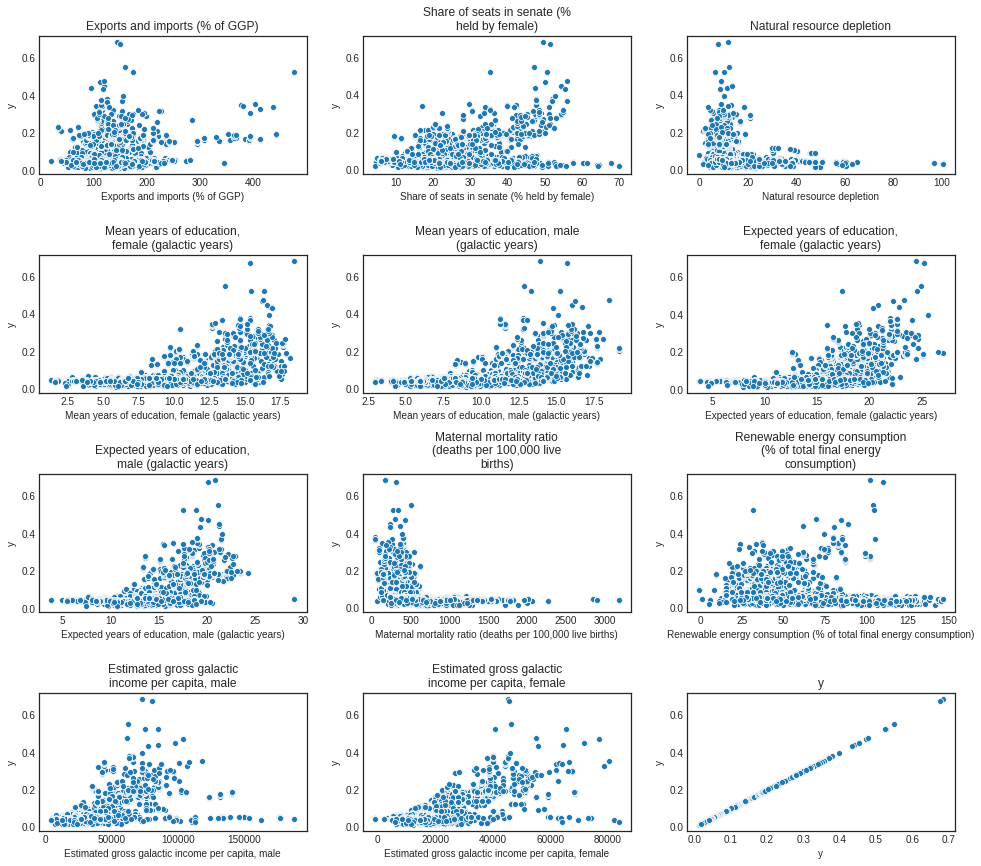

Box: 



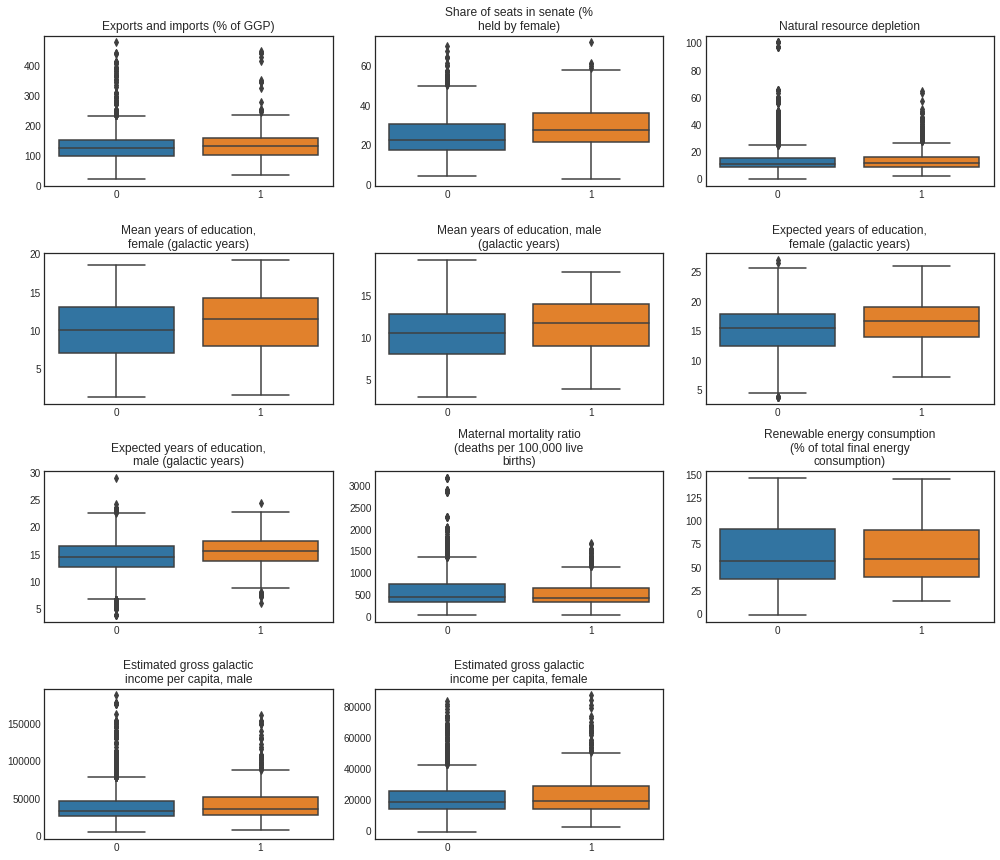

NaNs: 



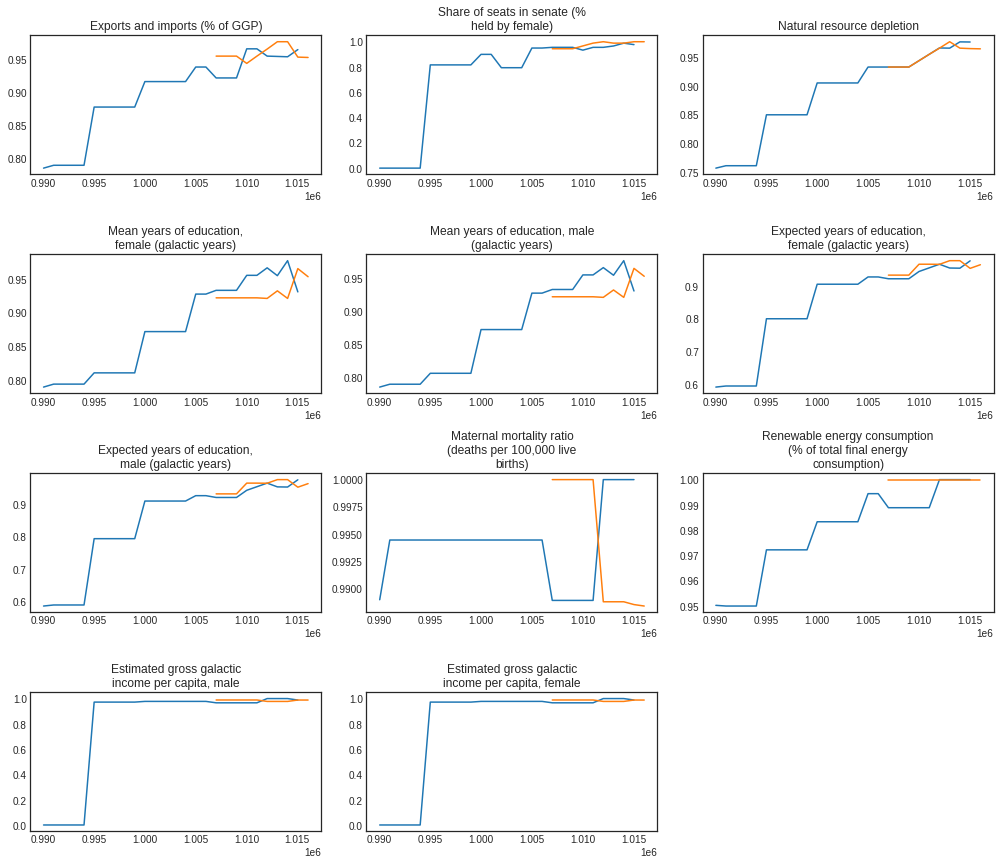

Data correlation: 



pearson  kendall  \
Exports and imports (% of GGP)                         0.20     0.11   
Share of seats in senate (% held by female)            0.42     0.15   
Natural resource depletion                            -0.22    -0.22   
Mean years of education, female (galactic years)       0.58     0.49   
Mean years of education, male (galactic years)         0.58     0.48   
Expected years of education, female (galactic y...     0.58     0.46   
Expected years of education, male (galactic years)     0.59     0.46   
Maternal mortality ratio (deaths per 100,000 li...    -0.39    -0.46   
Renewable energy consumption (% of total final ...    -0.28    -0.31   
Estimated gross galactic income per capita, male       0.48     0.42   
Estimated gross galactic income per capita, female     0.64     0.41   
y                                                      1.00     1.00   

                                                    spearman  skew  
Exports and imports (% of GGP)                          0.16  1.90  
Share of seats in senate (% held by female)             0.22  0.83  
Natural resource depletion                             -0.32  3.56  
Mean years of education, female (galactic years)        0.68  0.01  
Mean years of education, male (galactic years)          0.68  0.07  
Expected years of education, female (galactic y...      0.64 -0.37  
Expected years of education, male (galactic years)      0.63 -0.29  
Maternal mortality ratio (deaths per 100,000 li...     -0.65  2.01  
Renewable energy consumption (% of total final ...     -0.47  0.47  
Estimated gross galactic income per capita, male        0.59  2.20  
Estimated gross galactic income per capita, female      0.58  1.69  
y                                                       1.00  2.66

['Exports and imports (% of GGP)',
 'Share of seats in senate (% held by female)',
 'Natural resource depletion',
 'Mean years of education, female (galactic years)',
 'Mean years of education, male (galactic years)',
 'Expected years of education, female (galactic years)',
 'Expected years of education, male (galactic years)',
 'Maternal mortality ratio (deaths per 100,000 live births)',
 'Renewable energy consumption (% of total final energy consumption)',
 'Estimated gross galactic income per capita, male',
 'Estimated gross galactic income per capita, female']

In [145]:
data_desc(data_train, start_col=44)

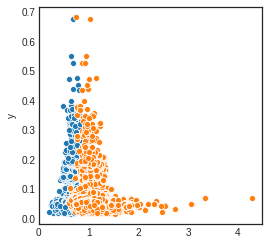

In [44]:
sns.scatterplot(x=data_train['Mean  years of education (galactic years)']/data_train['Expected years of education (galactic years)'],
                y=data_train['y'])

In [150]:
data_all['Years of education ratio'] = data_all['Mean years of education (galactic years)']/data_all['Expected years of education (galactic years)']

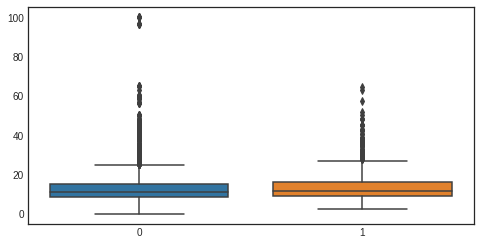

In [148]:
sns.boxplot(data=[data_train['Natural resource depletion'], data_test['Natural resource depletion']])

In [ ]:
features_drop += []

In [ ]:
features_with_outliers += ['Natural resource depletion',
                          'Expected years of education, male (galactic years)',
                          'Maternal mortality ratio (deaths per 100,000 live births)',
                          'Estimated gross galactic income per capita, male']

#### Группа 6:

Data description: 



Rural population with access to electricity (%)  \
count                                         2,755.00   
mean                                            107.40   
std                                              40.43   
min                                               1.53   
25%                                              73.91   
50%                                             123.85   
75%                                             138.27   
max                                             174.91   

       Domestic credit provided by financial sector (% of GGP)  \
count                                           3,148.00         
mean                                              112.10         
std                                                56.92         
min                                               -38.30         
25%                                                76.15         
50%                                                99.52         
75%                                               134.59         
max                                               555.80         

       Population with at least some secondary education, female (% ages 25 and older)  \
count                                           3,212.00                                 
mean                                               74.94                                 
std                                                29.88                                 
min                                                 7.79                                 
25%                                                51.45                                 
50%                                                72.87                                 
75%                                                99.32                                 
max                                               153.67                                 

       Population with at least some secondary education, male (% ages 25 and older)  \
count                                           3,209.00                               
mean                                               78.49                               
std                                                27.72                               
min                                                11.22                               
25%                                                57.60                               
50%                                                77.90                               
75%                                                99.89                               
max                                               150.70                               

       Gross fixed capital formation (% of GGP)  \
count                                  3,225.00   
mean                                      29.45   
std                                        7.65   
min                                        6.13   
25%                                       25.10   
50%                                       29.01   
75%                                       33.08   
max                                       75.08   

       Remittances, inflows (% of GGP)  \
count                         2,933.00   
mean                             11.59   
std                              10.17   
min                              -0.08   
25%                               7.36   
50%                               9.70   
75%                              12.63   
max                             172.73   

       Population with at least some secondary education (% ages 25 and older)  \
count                                           3,168.00                         
mean                                               75.76                         
std                                                28.62                         
min                                                 9.87                         
25%                                 

XY: 



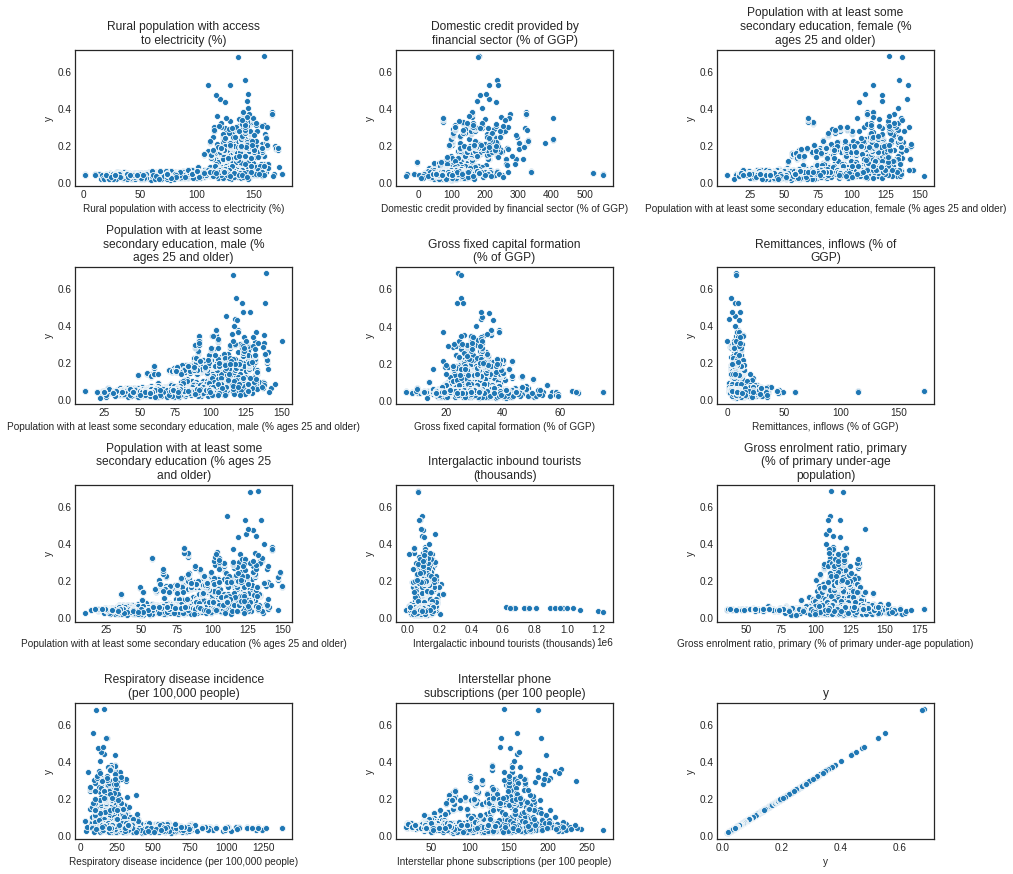

Box: 



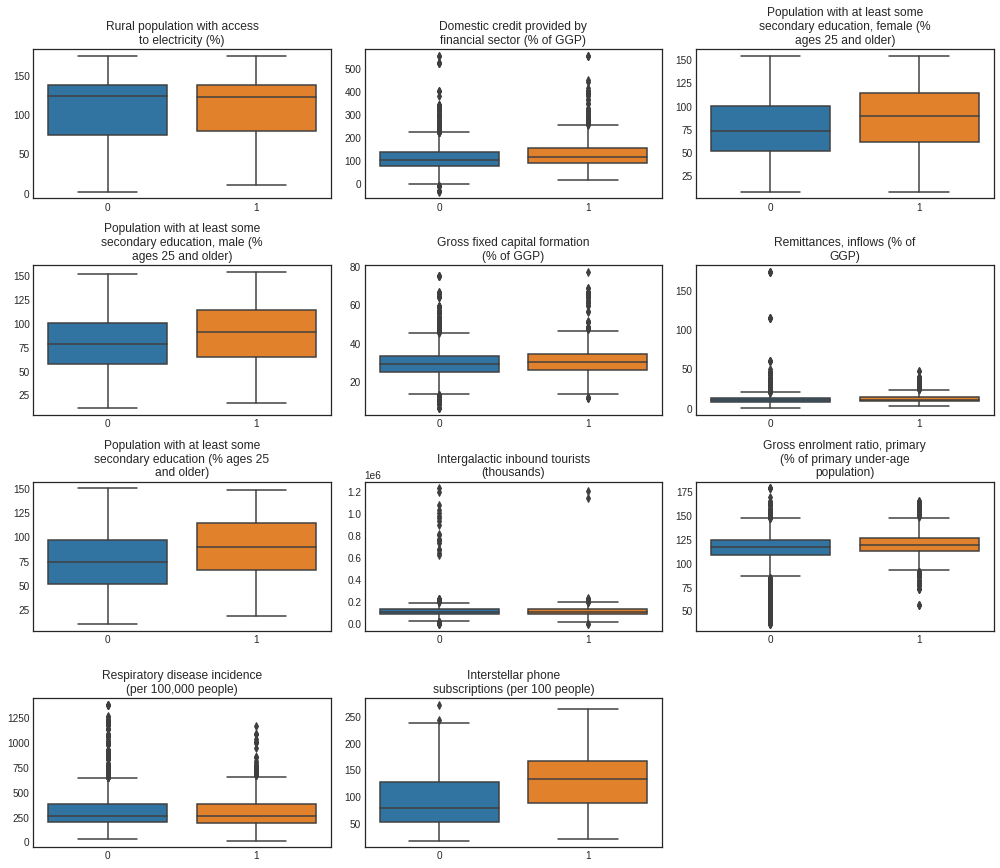

NaNs: 



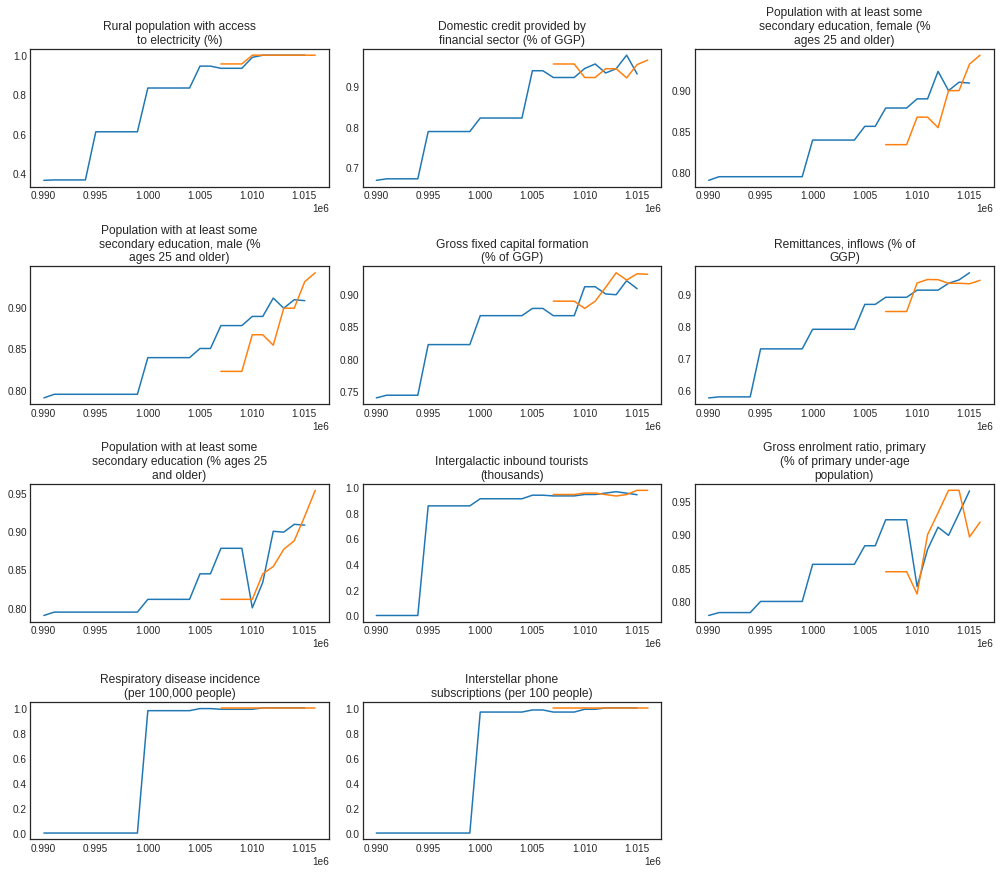

Data correlation: 



pearson  kendall  \
Rural population with access to electricity (%)        0.50     0.48   
Domestic credit provided by financial sector (%...     0.48     0.32   
Population with at least some secondary educati...     0.53     0.44   
Population with at least some secondary educati...     0.54     0.44   
Gross fixed capital formation (% of GGP)               0.09     0.13   
Remittances, inflows (% of GGP)                       -0.14    -0.12   
Population with at least some secondary educati...     0.51     0.42   
Intergalactic inbound tourists (thousands)             0.01     0.07   
Gross enrolment ratio, primary (% of primary un...     0.11     0.08   
Respiratory disease incidence (per 100,000 people)    -0.34    -0.34   
Interstellar phone subscriptions (per 100 people)      0.39     0.19   
y                                                      1.00     1.00   

                                                    spearman  skew  
Rural population with access to electricity (%)         0.67 -0.74  
Domestic credit provided by financial sector (%...      0.46  1.96  
Population with at least some secondary educati...      0.63  0.17  
Population with at least some secondary educati...      0.63  0.08  
Gross fixed capital formation (% of GGP)                0.18  0.92  
Remittances, inflows (% of GGP)                        -0.18  9.15  
Population with at least some secondary educati...      0.61  0.21  
Intergalactic inbound tourists (thousands)              0.10  8.97  
Gross enrolment ratio, primary (% of primary un...      0.12 -1.31  
Respiratory disease incidence (per 100,000 people)     -0.50  1.98  
Interstellar phone subscriptions (per 100 people)       0.27  0.68  
y                                                       1.00  2.66

['Rural population with access to electricity (%)',
 'Domestic credit provided by financial sector (% of GGP)',
 'Population with at least some secondary education, female (% ages 25 and older)',
 'Population with at least some secondary education, male (% ages 25 and older)',
 'Gross fixed capital formation (% of GGP)',
 'Remittances, inflows (% of GGP)',
 'Population with at least some secondary education (% ages 25 and older)',
 'Intergalactic inbound tourists (thousands)',
 'Gross enrolment ratio, primary (% of primary under-age population)',
 'Respiratory disease incidence (per 100,000 people)',
 'Interstellar phone subscriptions (per 100 people)']

In [149]:
data_desc(data_train, start_col=55)

In [153]:
data_train.loc[data_train['Remittances, inflows (% of GGP)'] > 100]['Remittances, inflows (% of GGP)'] = np.nan

In [151]:
features_drop += []
features_drop

['Population, total (millions)',
 'Population, ages 15–64 (millions)',
 'Population, ages 65 and older (millions)',
 'Population, under age 5 (millions)',
 'Gross galactic product (GGP), total']

In [ ]:
features_with_outliers += [
 'Domestic credit provided by financial sector (% of GGP)',
 'Gross fixed capital formation (% of GGP)',
 'Remittances, inflows (% of GGP)',
 'Intergalactic inbound tourists (thousands)',
]

#### Группа 7:

Data description: 



Interstellar Data Net users, total (% of population)  \
count                                           1,967.00      
mean                                               48.37      
std                                                26.49      
min                                                 0.51      
25%                                                29.85      
50%                                                39.44      
75%                                                62.22      
max                                               141.38      

       Current health expenditure (% of GGP)  \
count                               2,006.00   
mean                                    8.57   
std                                     2.65   
min                                     2.31   
25%                                     6.66   
50%                                     8.24   
75%                                    10.28   
max                                    23.53   

       Intergalactic Development Index (IDI), female  \
count                                       2,383.00   
mean                                            0.80   
std                                             0.19   
min                                             0.31   
25%                                             0.67   
50%                                             0.82   
75%                                             0.95   
max                                             1.24   

       Intergalactic Development Index (IDI), male  \
count                                     2,378.00   
mean                                          0.82   
std                                           0.16   
min                                           0.37   
25%                                           0.70   
50%                                           0.84   
75%                                           0.95   
max                                           1.18   

       Gender Development Index (GDI)  \
count                        2,373.00   
mean                             1.00   
std                              0.09   
min                              0.47   
25%                              0.95   
50%                              1.02   
75%                              1.06   
max                              1.18   

       Intergalactic Development Index (IDI), female, Rank  \
count                                           2,317.00     
mean                                              117.79     
std                                                44.52     
min                                                23.22     
25%                                                81.38     
50%                                               117.52     
75%                                               150.06     
max                                               232.72     

       Intergalactic Development Index (IDI), male, Rank  \
count                                           2,312.00   
mean                                              117.37   
std                                                44.25   
min                                                16.22   
25%                                                80.03   
50%                                               116.97   
75%                                               153.56   
max                                               233.92   

       Adjusted net savings   \
count               2,617.00   
mean                   21.18   
std                    14.16   
min                   -76.74   
25%                    15.20   
50%                    21.67   
75%                    29.13   
max                    61.90   

       Creature Immunodeficiency Disease prevalence, adult (% ages 15-49), total  \
count                                           2,875.00                           
mean                                                6.25                           
std

XY: 



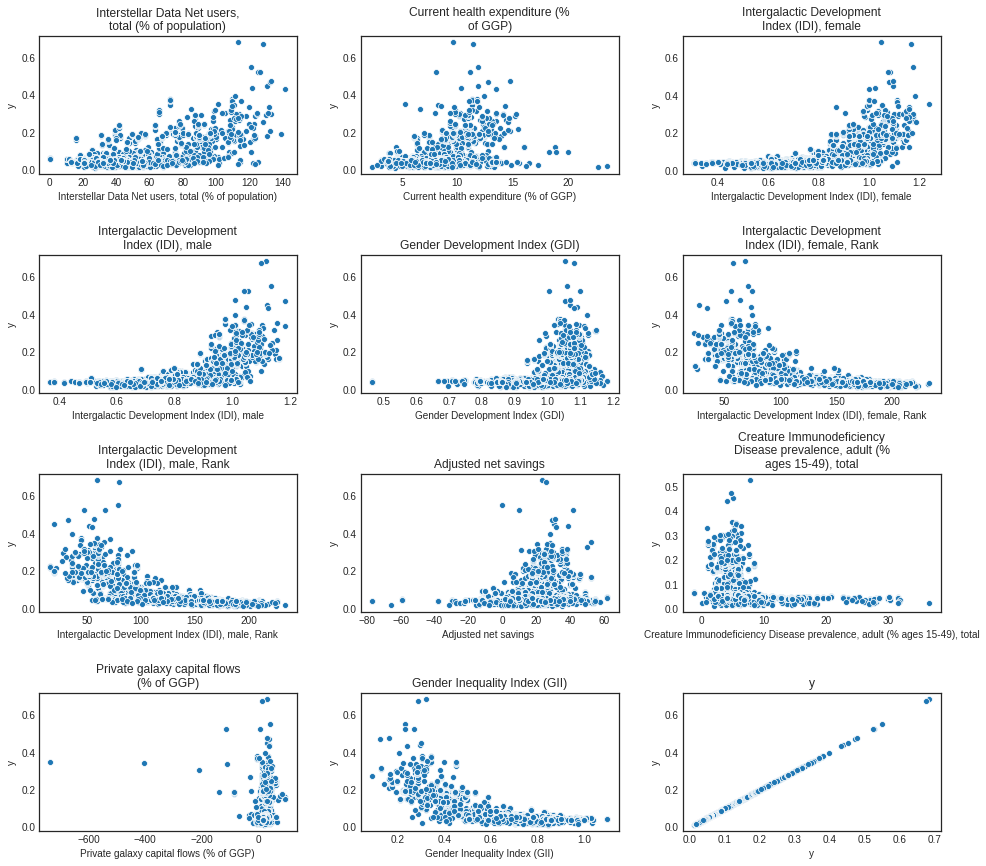

Box: 



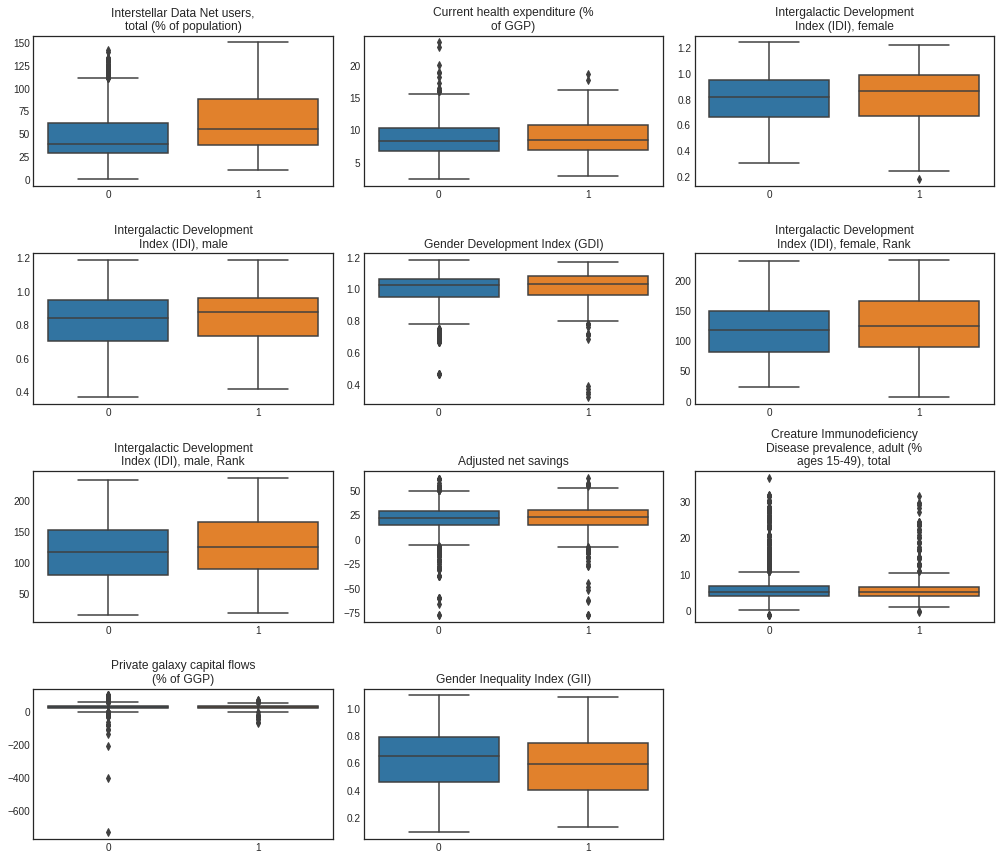

NaNs: 



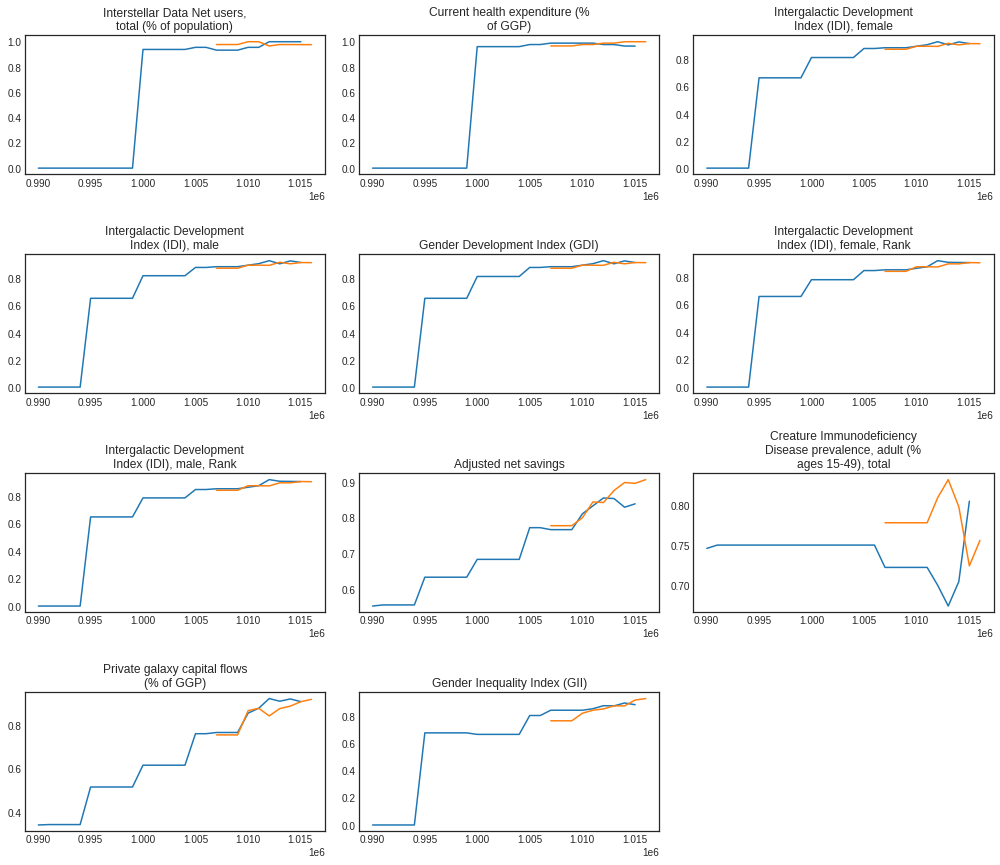

Data correlation: 



pearson  kendall  \
Interstellar Data Net users, total (% of popula...     0.64     0.30   
Current health expenditure (% of GGP)                  0.37     0.22   
Intergalactic Development Index (IDI), female          0.64     0.57   
Intergalactic Development Index (IDI), male            0.64     0.57   
Gender Development Index (GDI)                         0.37     0.35   
Intergalactic Development Index (IDI), female, ...    -0.67    -0.62   
Intergalactic Development Index (IDI), male, Rank     -0.69    -0.64   
Adjusted net savings                                   0.16     0.14   
Creature Immunodeficiency Disease prevalence, a...    -0.25    -0.30   
Private galaxy capital flows (% of GGP)               -0.08     0.02   
Gender Inequality Index (GII)                         -0.75    -0.58   
y                                                      1.00     1.00   

                                                    spearman   skew  
Interstellar Data Net users, total (% of popula...      0.44   1.11  
Current health expenditure (% of GGP)                   0.31   0.60  
Intergalactic Development Index (IDI), female           0.76  -0.30  
Intergalactic Development Index (IDI), male             0.76  -0.36  
Gender Development Index (GDI)                          0.52  -1.27  
Intergalactic Development Index (IDI), female, ...     -0.81   0.13  
Intergalactic Development Index (IDI), male, Rank      -0.83   0.07  
Adjusted net savings                                    0.20  -1.16  
Creature Immunodeficiency Disease prevalence, a...     -0.45   3.12  
Private galaxy capital flows (% of GGP)                 0.03 -18.33  
Gender Inequality Index (GII)                          -0.78  -0.26  
y                                                       1.00   2.66

['Interstellar Data Net users, total (% of population)',
 'Current health expenditure (% of GGP)',
 'Intergalactic Development Index (IDI), female',
 'Intergalactic Development Index (IDI), male',
 'Gender Development Index (GDI)',
 'Intergalactic Development Index (IDI), female, Rank',
 'Intergalactic Development Index (IDI), male, Rank',
 'Adjusted net savings ',
 'Creature Immunodeficiency Disease prevalence, adult (% ages 15-49), total',
 'Private galaxy capital flows (% of GGP)',
 'Gender Inequality Index (GII)']

In [152]:
data_desc(data_train, start_col=66)

In [154]:
data_train.loc[data_train['Private galaxy capital flows (% of GGP)'] < -100]['Private galaxy capital flows (% of GGP)'] = np.nan

In [ ]:
features_drop += []

In [ ]:
features_with_outliers += [
 'Adjusted net savings ',
 'Creature Immunodeficiency Disease prevalence, adult (% ages 15-49), total',
 'Private galaxy capital flows (% of GGP)',]

In [155]:
features_drop = list(set(features_drop))
features_with_outliers = list(set(features_with_outliers))
features_drop, features_with_outliers

(['Population, total (millions)',
  'Population, ages 65 and older (millions)',
  'Population, ages 15–64 (millions)',
  'Population, under age 5 (millions)',
  'Gross galactic product (GGP), total'],
 [])

### Группы

In [163]:
features_indexes = [x for x in data_all.columns if 'index' in (x.lower())]
features_gender = [x for x in data_all.columns if 'male' in (x.lower())]
features_rank = [x for x in data_all.columns if 'rank' in (x.lower())]
features_indexes, features_gender, features_rank

(['existence expectancy index',
  'Income Index',
  'Intergalactic Development Index (IDI)',
  'Education Index',
  'Intergalactic Development Index (IDI), Rank',
  'Intergalactic Development Index (IDI), female',
  'Intergalactic Development Index (IDI), male',
  'Gender Development Index (GDI)',
  'Intergalactic Development Index (IDI), female, Rank',
  'Intergalactic Development Index (IDI), male, Rank',
  'Gender Inequality Index (GII)'],
 ['Life expectancy at birth, male (galactic years)',
  'Life expectancy at birth, female (galactic years)',
  'Adolescent birth rate (births per 1,000 female creatures ages 15-19)',
  'Total unemployment rate (female to male ratio)',
  'Labour force participation rate (% ages 15 and older), female',
  'Labour force participation rate (% ages 15 and older), male',
  'Share of employment in nonagriculture, female (% of total employment in nonagriculture)',
  'Youth unemployment rate (female to male ratio)',
  'Mortality rate, female grown up (per 1,

### check disribution (not done)

### percent cols (not done)

cols_percent = [x for x in data_train.columns if ('%' in x)]
cols_percent = [x for x in cols_percent if (any(data_train[x] > 100))]
(data_train[cols_percent] > 100).sum()

Будем считать, что у инопланетян другие проценты с максимумом > 100%

# Models

## Boosting

In [85]:
#Common Model Algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process, neural_network
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn import metrics

#alg = ensemble.GradientBoostingRegressor(criterion='mse', random_state=111)
#xgb_model = XGBRegressor(n_estimators=50, max_depth=3, random_state=45)
xgb_model = neural_network.MLPRegressor(hidden_layer_sizes=(128,128,128), random_state=121, max_iter=400)
#split dataset in cross-validation with this splitter class: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html#sklearn.model_selection.ShuffleSplit
#note: this is an alternative to train_test_split
cv_split = ShuffleSplit(n_splits = 20, test_size = .2, train_size = .8, random_state = 0 ) # run model 10x with 60/30 split intentionally leaving out 10%

train_X = data_train.iloc[:,:-1]
train_y = data_train.iloc[:,[-1]]

train_X = fnl.fit_transform(train_X)
train_y = transform_y.fit_transform(train_y)

#score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
cv_results = cross_validate(xgb_model, train_X, train_y, \
                                            cv  = cv_split, return_train_score=True, scoring='neg_mean_squared_error')

print(cv_results['fit_time'].mean())
print(cv_results['train_score'].mean())
print(cv_results['test_score'].mean())
    #if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
print(cv_results['test_score'].std()*3)   #let's know the worst that can happen!
    

xgb_model.fit(train_X, train_y)

#lr_model.fit(train_X, train_y, epochs=epochs, verbose=0, batch_size=batch_size)

pred_X = data_test.sort_index().reset_index(drop=True).copy()

pred_X = fnl.transform(pred_X)
pred_y = xgb_model.predict(pred_X)
pred_y = transform_y.inverse_transform(pred_y)



3.1857704877853394
-0.0011016932242381876
-0.0012908786067736483
0.0005000268809100829


In [86]:
pred_y.max(), pred_y.min(), pred_y.mean()

(0.4321249465872814, -0.033907109775007147, 0.08827180308858225)

In [ ]:
kf = KFold(n_splits=10, random_state=311, shuffle=True)

train_X = data_train.iloc[:,:-1]
train_y = data_train.iloc[:,[-1]]

train_X = fnl.fit_transform(train_X)
train_y = transform_y.fit_transform(train_y)

#score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
cv_results = cross_validate(xgb_model, train_X, train_y, \
                                            cv  = kf, return_train_score=True, scoring='neg_mean_squared_error')

print(cv_results['fit_time'].mean())
print(cv_results['train_score'].mean())
print(cv_results['test_score'].mean())
    #if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
print(cv_results['test_score'].std()*3)   #let's know the worst that can happen!
    

xgb_model.fit(train_X, train_y)

#lr_model.fit(train_X, train_y, epochs=epochs, verbose=0, batch_size=batch_size)

pred_X = data_test.sort_index().reset_index(drop=True).copy()

pred_X = fnl.transform(pred_X)
pred_y = xgb_model.predict(pred_X)
pred_y = transform_y.inverse_transform(pred_y)


## Neural Network

### train_df, test_df

In [164]:
data_all = data_all.drop('y', axis=1).join(data_all['y'])

data_train = data_all.loc['train']
data_test = data_all.loc['test'].drop('y', axis=1)
print(data_train.shape, data_test.shape)

(3865, 87) (890, 86)


In [169]:
data_wrk = data_train.copy() #.loc[data_train['galactic year'] >= 1000000]

train_df, test_df = train_test_split(data_wrk, test_size=0.2, random_state=13)

# outliers
#train_df_outliers = train_df.loc[((train_df['y'].mean() - 3 * train_df['y'].std()) >= train_df['y']) ^ \
#                        (train_df['y'] >= (train_df['y'].mean() + 3 * train_df['y'].std()))]

#for i in range(20):
#    train_df = train_df.append(train_df_outliers)

print(train_df.shape, test_df.shape);


train_X = train_df.iloc[:,:-1]
train_y = train_df.iloc[:,[-1]]

test_X = test_df.iloc[:,:-1]
test_y = test_df.iloc[:,[-1]]

# preprocess
def preprop_wrk(data, features=[], drop=[]):
    drop += ['galaxy', 'galactic year']
    data.drop(drop, axis=1, inplace=True)
#    data[data < 0] = np.nan
    if not features:
        features = data.columns
    return data[features]

features = []
drop = []
# features = corr_cols
drop = features_drop + features_gender
preprop = FunctionTransformer(preprop_wrk, kw_args={'features': features, 'drop': drop})

# imputer
imp = SimpleImputer(strategy='median', 
                    #fill_value=0
                   )
#imp = KNNImputer()

#scaler
scale_X = MaxAbsScaler()
#scale_X = MinMaxScaler()
#scale_X = StandardScaler()


# missing indicator
ind = MissingIndicator(features='all')

fnl = make_pipeline(preprop, 
                    make_union(ind, 
                               make_pipeline(imp, 
                                             #norm,
                                             scale_X, 
                                             ),
                              ),                    
                   )

train_X = fnl.fit_transform(train_X)
test_X = fnl.transform(test_X)

transform_y = make_pipeline(
                FunctionTransformer(func=(lambda y: y), inverse_func=(lambda y: y)),
                #FunctionTransformer(func=(lambda y: y ** (-1/4) / 10), inverse_func=(lambda y: (10 * y) ** (-4))),
                #MinMaxScaler(),
                )

train_y = transform_y.fit_transform(train_y)
test_y = transform_y.transform(test_y)


from sklearn.utils import shuffle
train_X, train_y = shuffle(train_X, train_y, random_state=87)

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape);
print(train_y.agg(['max', 'min']))

(3092, 87) (773, 87)
(3092, 112) (3092, 1) (773, 112) (773, 1)
       y
max 0.68
min 0.01


#### Хорошие модели

### Create model

In [170]:
def create_model(input_dim, learn_rate=0.001, dropout=.0, dims=[128], l2=1e-9):

    lr_model = keras.models.Sequential()
    lr_model.add(keras.Input(shape=(input_dim,) ))
    lr_model.add(keras.layers.Dense(dims[0], activation='relu', ))
    lr_model.add(keras.layers.Dropout(dropout))
    for dim in dims[1:]:

        lr_model.add(keras.layers.Dense(dim, activation='relu', kernel_initializer='random_uniform', 
#                                   kernel_regularizer=keras.regularizers.l2(l2),
                                   ))

    #                use_bias=True,
    #                kernel_regularizer=keras.regularizers.l2(1e-6),
    #                bias_regularizer=keras.regularizers.l2(1e-10),
    #                activity_regularizer=keras.regularizers.l2(1e-10)               



    lr_model.add(keras.layers.Dense(1, activation='linear', kernel_initializer='random_uniform'
                                   ))

    # compile the model
    lr_model.compile(loss='mean_squared_error', 
                  optimizer=keras.optimizers.Adam(learning_rate=learn_rate), # keras.optimizers.RMSprop(lr=learn_rate),
                  metrics=[keras.metrics.RootMeanSquaredError()])
    return lr_model

def plot_history(history):
    epochs = history.epoch

    hist = pd.DataFrame(history.history)
    if "val_root_mean_squared_error" in hist.columns:
        rmse = hist[["root_mean_squared_error", "val_root_mean_squared_error"]]
    else:
        rmse = hist[["root_mean_squared_error",]]

    rcParams['figure.figsize'] = 8, 4

    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Root Mean Squared Error")

    plt.plot(epochs, rmse, label=list(rmse.columns))
    plt.legend(list(rmse.columns))
    plt.ylim([min(rmse.min())*0.94, max(rmse.max())* 1.05])
    plt.show()

def compute_sample_weights(y, bins=10):
    hist, bin_edges = np.histogram(y, bins = bins)
    classes = y.apply(lambda x: pd.cut(x, bin_edges, labels = False, 
                                                  include_lowest = True)).values
    sample_weights = compute_sample_weight('balanced', classes)
    return sample_weights

### Train, plot, eval

In [171]:
np.exp(0 * (10 - 100))

1.0

In [172]:
sample_bins = 10
set(compute_sample_weights(train_y, sample_bins))

{0.13760569648420115,
 0.8052083333333333,
 0.96625,
 3.4355555555555557,
 9.36969696969697,
 38.65,
 61.84,
 154.6,
 309.2}

Epoch 1/200
1/1 [==============================] - 0s 247ms/step - loss: 0.0121 - root_mean_squared_error: 0.1099 - val_loss: 0.0124 - val_root_mean_squared_error: 0.1115 - lr: 1.0000e-04
Epoch 2/200
1/1 [==============================] - 0s 157ms/step - loss: 0.0115 - root_mean_squared_error: 0.1073 - val_loss: 0.0119 - val_root_mean_squared_error: 0.1092 - lr: 1.0000e-04
Epoch 3/200
1/1 [==============================] - 0s 144ms/step - loss: 0.0110 - root_mean_squared_error: 0.1048 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1070 - lr: 1.0000e-04
Epoch 4/200
1/1 [==============================] - 0s 163ms/step - loss: 0.0105 - root_mean_squared_error: 0.1024 - val_loss: 0.0110 - val_root_mean_squared_error: 0.1048 - lr: 1.0000e-04
Epoch 5/200
1/1 [==============================] - 0s 153ms/step - loss: 0.0100 - root_mean_squared_error: 0.1001 - val_loss: 0.0105 - val_root_mean_squared_error: 0.1027 - lr: 1.0000e-04
Epoch 6/200
1/1 [==============================] - 0s 203ms/

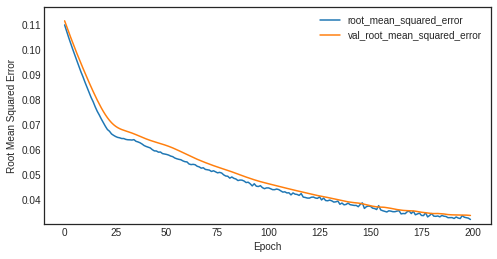

In [186]:
np.random.seed(51)

first_layer = train_X.shape[1]
# 0.0708 lr_model = create_model(first_layer, learn_rate=0.001, dropout=.01, dims=[154, 154], l2=1e-11)

learn_rate = 0.0001
batch_size = int(train_X.shape[0]/1) # 
epochs = 200 # 100
sample_bins = 1

def scheduler(epoch, learn_rate):
    if epoch < 10:
        return learn_rate
    else:
        return learn_rate * np.exp(0.0 * (10 - epoch))

lr_scheduler = keras.callbacks.LearningRateScheduler(scheduler)
early_stopping = keras.callbacks.EarlyStopping(monitor='loss', patience=10)
callbacks = [lr_scheduler, 
            # early_stopping
            ]

lr_model = create_model(first_layer, learn_rate=learn_rate, dropout=.3, dims=[160, 160, 160], l2=1e-11)


history = lr_model.fit(train_X, train_y, validation_split=.2, sample_weight=compute_sample_weights(train_y, sample_bins),
                       callbacks=callbacks, epochs=epochs, verbose=1, batch_size=batch_size)
print()
scores = lr_model.evaluate(x=test_X, y=test_y, batch_size=test_X.shape[0])

# plot
plot_history(history)

In [185]:
val = pd.DataFrame(transform_y.inverse_transform(lr_model.predict(test_X))).join(test_y.reset_index())
val['dif'] = abs(val[0] - val['y'])
val.sort_values('dif', ascending=False)

0  index    y  dif
32  0.15   3630 0.31 0.16
140 0.22   3647 0.36 0.14
299 0.23   3785 0.35 0.11
654 0.11   2345 0.22 0.10
686 0.19   1318 0.29 0.10
128 0.12   2554 0.22 0.10
230 0.11   2223 0.21 0.10
314 0.20   3594 0.30 0.09
623 0.10     94 0.20 0.09
258 0.25   1134 0.34 0.09
385 0.11   1296 0.20 0.08
469 0.12    507 0.20 0.08
101 0.11   2912 0.19 0.08
622 0.23   3664 0.30 0.07
512 0.13    227 0.20 0.07
370 0.27   1404 0.34 0.07
239 0.07   2326 0.14 0.07
273 0.08   2598 0.14 0.07
663 0.29   3539 0.35 0.07
509 0.08   1344 0.14 0.06
99  0.17   1749 0.24 0.06
213 0.10   2877 0.16 0.06
102 0.09   3307 0.15 0.06
242 0.09   3021 0.15 0.06
376 0.32   2579 0.38 0.06
711 0.07    193 0.13 0.06
35  0.06   3149 0.12 0.06
753 0.22    267 0.27 0.06
86  0.24   3609 0.29 0.06
146 0.27   1034 0.33 0.06
291 0.14   3387 0.19 0.05
709 0.09   1841 0.15 0.05
511 0.11    932 0.16 0.05
425 0.12   2165 0.17 0.05
279 0.05    686 0.11 0.05
363 0.12   2377 0.17 0.05
734 0.14   3461 0.19 0.05
48  0.32   2105 0.37 0.05
479 0.09   2562 0.13 0.05
636 0.09   1055 0.14 0.05
450 0.27   2457 0.32 0.05
526 0.06   2205 0.11 0.05
572 0.42   3370 0.37 0.05
547 0.11   1295 0.16 0.05
43  0.21   2061 0.25 0.05
237 0.06    864 0.11 0.05
723 0.06   2112 0.11 0.05
769 0.28    346 0.32 0.05
721 0.13    402 0.18 0.05
657 0.09   1052 0.13 0.05
524 0.15   2884 0.11 0.05
676 0.13    141 0.17 0.04
717 0.09   1223 0.13 0.04
150 0.07   2151 0.11 0.04
486 0.09     47 0.13 0.04
180 0.11     40 0.15 0.04
641 0.10   3134 0.14 0.04
153 0.06   2144 0.10 0.04
408 0.12    158 0.16 0.04
545 0.12   1915 0.16 0.04
220 0.07   2589 0.11 0.04
503 0.18   1772 0.22 0.04
493 0.17    958 0.21 0.04
710 0.11   1120 0.14 0.04
7   0.07   2908 0.11 0.04
727 0.08   2498 0.11 0.04
632 0.12    857 0.15 0.04
167 0.21   3008 0.17 0.04
536 0.07   1853 0.11 0.04
371 0.06   2902 0.10 0.04
75  0.06    816 0.10 0.04
655 0.10   2482 0.13 0.04
113 0.24   3566 0.28 0.04
756 0.13   2425 0.17 0.04
535 0.10   1586 0.13 0.04
482 0.10    479 0.14 0.04
52  0.15   1567 0.18 0.03
548 0.18   3066 0.22 0.03
382 0.16   2534 0.19 0.03
317 0.07   2072 0.11 0.03
668 0.18   3483 0.21 0.03
142 0.07    173 0.10 0.03
57  0.24   1277 0.27 0.03
495 0.12    428 0.15 0.03
563 0.21   3352 0.18 0.03
53  0.06    289 0.09 0.03
121 0.07    918 0.10 0.03
322 0.16   1251 0.19 0.03
225 0.07    139 0.10 0.03
601 0.15   1420 0.18 0.03
640 0.07   1158 0.10 0.03
315 0.15   1210 0.18 0.03
683 0.11   3185 0.14 0.03
740 0.11   3518 0.14 0.03
199 0.33   3729 0.30 0.03
344 0.07   3222 0.10 0.03
144 0.06    646 0.09 0.03
85  0.27   2602 0.30 0.03
694 0.15   2001 0.18 0.03
159 0.16   2488 0.19 0.03
591 0.07    787 0.09 0.03
368 0.11   1923 0.13 0.03
115 0.07   2186 0.10 0.03
207 0.07     84 0.10 0.03
666 0.06   3363 0.09 0.03
735 0.07   2315 0.10 0.03
589 0.14   1808 0.17 0.03
718 0.06   1226 0.09 0.03
6   0.15     12 0.18 0.03
284 0.06   1367 0.09 0.03
224 0.05   3638 0.08 0.03
272 0.16   2014 0.19 0.03
223 0.06    606 0.08 0.03
488 0.16   1030 0.18 0.03
179 0.14   2533 0.17 0.03
222 0.05   2030 0.08 0.03
673 0.05   2039 0.08 0.03
544 0.24   3784 0.27 0.03
647 0.07   1614 0.10 0.03
555 0.07   2520 0.10 0.03
67  0.11    618 0.14 0.03
691 0.09   1683 0.11 0.03
108 0.06    530 0.09 0.03
160 0.09   3856 0.06 0.03
250 0.27   1942 0.30 0.03
369 0.12    798 0.14 0.03
407 0.08   1746 0.10 0.02
766 0.06   1739 0.09 0.02
303 0.16   1564 0.19 0.02
404 0.04   3371 0.06 0.02
227 0.34   3200 0.37 0.02
107 0.16   1709 0.19 0.02
588 0.09   3636 0.07 0.02
342 0.06   3540 0.09 0.02
331 0.22   3589 0.19 0.02
133 0.14   1452 0.16 0.02
229 0.06   1583 0.08 0.02
251 0.05   1815 0.07 0.02
233 0.05     59 0.07 0.02
765 0.13    221 0.15 0.02
95  0.05   2868 0.07 0.02
123 0.05    801 0.08 0.02
208 0.04   1242 0.07 0.02
523 0.06   2088 0.08 0.02
609 0.08   2540 0.10 0.02
63  0.26   2943 0.29 0.02
661 0.07    784 0.09 0.02
294 0.04   2155 0.06 0.02
658 0.06    419 0.08 0.02
112 0.06    794 0.08 0.02
520 0.05   1245 0.07 0.02
84  0.05   2796 0.07 0.02
458 0.15   1740 0.17 0.02
358

In [ ]:
#saved_model = lr_model.get_config()

## KFold and ShuffleSplit

In [ ]:
kfold_history = []
kfold_scores = []
kfold_models = []

kf = KFold(n_splits=10, random_state=311, shuffle=True)
for train_index, test_index in kf.split(data_wrk):
    # prepare data
    train_df, test_df = data_wrk.iloc[train_index], data_wrk.iloc[test_index]

    train_X = train_df.iloc[:,:-1]
    train_y = train_df.iloc[:,[-1]]

    test_X = test_df.iloc[:,:-1]
    test_y = test_df.iloc[:,[-1]]

    train_X = fnl.fit_transform(train_X)
    test_X = fnl.transform(test_X)

    train_y = transform_y.fit_transform(train_y)
    test_y = transform_y.transform(test_y)

    # create model
#    first_layer = train_X.shape[1]
#    lr_model = create_model(first_layer, learn_rate=0.0001, dropout=.05, dims=[80, 80], l2=1e-11)

#    batch_size=25 # 5
#    epochs=100 # 100

    kfold_history.append(lr_model.fit(train_X, train_y, validation_split=0., sample_weight=compute_sample_weights(train_y, sample_bins),
                                      callbacks=[callback], epochs=epochs, verbose=0, batch_size=batch_size))
    print()
    kfold_scores.append(lr_model.evaluate(x=test_X, y=test_y, batch_size=1))
    kfold_models.append(lr_model)
    plot_history(kfold_history[-1])
#print(kfold_scores)
print('Mean error: ', np.mean([x[1] for x in kfold_scores]))
print('Std * 3:', np.std([x[1] for x in kfold_scores]) * 3)

In [ ]:
shuffle_history = []
shuffle_scores = []
shuffle_models = []

cv_split = ShuffleSplit(n_splits = 20, test_size = .2, train_size = .7, random_state = 777 ) # run model 10x with 60/30 split intentionally leaving out 10%

for train_index, test_index in cv_split.split(data_wrk):
    # prepare data
    train_df, test_df = data_wrk.iloc[train_index], data_wrk.iloc[test_index]

    train_X = train_df.iloc[:,:-1]
    train_y = train_df.iloc[:,[-1]]

    test_X = test_df.iloc[:,:-1]
    test_y = test_df.iloc[:,[-1]]

    train_X = fnl.fit_transform(train_X)
    test_X = fnl.transform(test_X)

    train_y = transform_y.fit_transform(train_y)
    test_y = transform_y.transform(test_y)

    # create model
#    first_layer = train_X.shape[1]
#    lr_model = create_model(first_layer, learn_rate=0.0001, dropout=.05, dims=[80, 80], l2=1e-11)

#    batch_size=25 # 5
#    epochs=100 # 100

    shuffle_history.append(lr_model.fit(train_X, train_y, validation_split=0., sample_weight=compute_sample_weights(train_y, sample_bins),
                                        callbacks=[callback], epochs=epochs, verbose=0, batch_size=batch_size))
    print()
    shuffle_scores.append(lr_model.evaluate(x=test_X, y=test_y, batch_size=1))
    shuffle_models.append(lr_model)
    plot_history(shuffle_history[-1])
print('Mean error: ', np.mean([x[1] for x in shuffle_scores]))
print('Std * 3:', np.std([x[1] for x in shuffle_scores]) * 3)

## NN Feature selection

## Ensemble NN

In [ ]:
# cross validation estimation of performance
n_folds = 10
kfold = KFold(n_folds, True, 1)
scores, members = list(), list()
for train_ix, test_ix in kfold.split(data_wrk):
	# select samples
	train_X, train_y = X[train_ix], y[train_ix]
	test_X, test_y = X[test_ix], y[test_ix]
	# evaluate model
	model, test_acc = evaluate_model(train_X, train_y, test_X, test_y)
	print('>%.3f' % test_acc)
	scores.append(test_acc)
	members.append(model)

# Predict

In [ ]:
# data for fit
data_wrk = data_train.copy()

#data_wrk = data_wrk.loc[data_wrk['galactic year'] >= 1000000]

#outliers
data_wrk_outliers = data_wrk.loc[((data_wrk['y'].mean() - 3 * data_wrk['y'].std()) >= data_wrk['y']) ^ \
                        (data_wrk['y'] >= (data_wrk['y'].mean() + 3 * data_wrk['y'].std()))]

#for i in range(20):
#    data_wrk = data_wrk.append(data_wrk_outliers)
    
train_X = data_wrk.iloc[:,:-1]
train_y = data_wrk.iloc[:,[-1]]

train_X = fnl.fit_transform(train_X)
train_y = transform_y.fit_transform(train_y)

lr_model.fit(train_X, train_y, sample_weight=compute_sample_weights(train_y, sample_bins), 
                callbacks=[callback], epochs=epochs, verbose=0, batch_size=batch_size)

pred_X = data_test.sort_index().reset_index(drop=True).copy()

pred_X = fnl.transform(pred_X)
pred_y = lr_model.predict(pred_X, batch_size=batch_size)
pred_y = transform_y.inverse_transform(pred_y)
pred_y.max(), pred_y.min(), pred_y.mean(), pred_y.std()

In [ ]:
data_all_final = pd.concat([data_train, data_test.join(pd.DataFrame(pred_y, columns=['y']))], keys=['train', 'test'])
data_all_final.sort_values(by='y', ascending=False).iloc[:20].transpose()


# Energy split

In [ ]:
from scipy.optimize import Bounds, LinearConstraint, minimize, HessianUpdateStrategy
import numpy as np
import pandas as pd

pred = pred_y.reshape(1,-1)[0]
sz = len(pred)

def func_en(En):
    #print(-sum(En * ((-np.log(pred + 0.01) + 3) ** 2 / 1000)))
    return -sum(En * ((-np.log(pred + 0.01) + 3) ** 2 / 1000))

bounds = Bounds(0, 1)
linear_constraint = LinearConstraint([np.array(data_test['existence expectancy index'] < 0.7).astype('float'),
                                      np.ones(sz)], [50, 0], [np.inf, 500])

En0 = np.random.random(sz);
res = minimize(func_en, En0, method='trust-constr', jac='2-point', \
                   constraints=[linear_constraint], \
                   options={'verbose': 1}, bounds=bounds)


In [ ]:
res.fun
#16.84650144962803
#17.935576687882783
#18.828106719581477

In [ ]:
from scipy.optimize import basinhopping
minimizer_kwargs = {"method":"trust-constr", "jac":'2-point', 'constraints':[linear_constraint], 'bounds': bounds}
En0 = np.random.random(sz);
ret = basinhopping(func_en, En0, minimizer_kwargs=minimizer_kwargs,
                    niter=10)

In [ ]:
ret.fun
#-16.84617913608769

# Prepare submit

In [ ]:

data_submit = pd.DataFrame()
data_submit['pred'] = pred
data_submit['opt_pred'] = res.x * 100
data_submit.reset_index().to_csv('submit.csv', index=False, float_format='%.8f')

In [ ]:
(pd.concat([pd.read_csv('submit.csv')['opt_pred'], pd.Series(res.x*100)], axis=1)).sum()